In [9]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_descriptor(filename,desc_size) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(desc_size) :
                desc.append(float(row[i+1]))
            descriptors.append(desc)
        return np.array(descriptors)
    
def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

In [10]:
def compute_dataframe(pmni_folder,gen_method,eval_budget,start_fit):
    lines = []
    fives = ([],[],[],[],[],[],[],[]) #wheel,sensor,joint
    allofthem = ([],[],[],[],[],[],[],[])
    desc_array = []
    best_fit_array = []
    key_array = []
    nbr_eval_array = []
    folder_array = []
    number_per_run = []
    number_per_run_025 = []
    number_per_run_05 = []
    number_per_run_075 = []
    nbr_start = 0
    for folder in os.listdir(pmni_folder) :
        parameters = read_parameters(pmni_folder + folder + '/parameters.csv')
        descriptors = load_descriptor("/home/leni/git/genomes/20201127_noSegmentedRobots/" + gen_method + "/" + parameters["#loadExperiment"].split('/')[-2] + "/MD_Cart_WDH.csv",8)
        best_fit_dict = dict()
        avg_fit_dict = dict()
        nbr_eval_dict = dict()
        nbr = 0
        nbr_025 = 0
        nbr_05 = 0
        nbr_075 = 0 
        for morph_dir in os.listdir(pmni_folder + folder) :
            if(morph_dir.split('_')[0] != "morph"):
                continue
            neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(pmni_folder + folder + '/'+ morph_dir + "/fitnesses.csv",0)        
            if(len(best_fit)==0):
                continue
            if(eval_budget < 1000):
                tot=0
                i = 0
                for ps in pop_size:
                    tot+=ps
                    i+=1
                    if(tot >= eval_budget):
                        break
                best_fit = best_fit[:i]
                
            key = int(morph_dir.split('_')[1])
            best_fit_array.append(max(best_fit))
            nbr_eval_array.append(neval[-1])
            if(max(best_fit) >= 0.95):
                nbr+=1
            if(max(best_fit) >= 0.91):
                nbr_025+=1
            if(max(best_fit) >= 0.82):
                nbr_05+=1
            if(max(best_fit) >= 0.73):
                nbr_075+=1
            if(max(best_fit) > start_fit):
                nbr_start+=1
            desc_array.append(descriptors[key])
            key_array.append(key)
            folder_array.append(parameters["#loadExperiment"].split('/')[-2])
            if(best_fit_dict.__contains__(key)) :
                best_fit_dict[key].append(max(best_fit))
                avg_fit_dict[key].append(max(avg_fit))
                nbr_eval_dict[key].append(neval[-1])
            else :
                best_fit_dict.update({key:[max(best_fit)]})
                avg_fit_dict.update({key:[max(avg_fit)]})
                nbr_eval_dict.update({key:[neval[-1]]})
        number_per_run.append(nbr)
        number_per_run_025.append(nbr_025)
        number_per_run_05.append(nbr_05)
        number_per_run_075.append(nbr_075)
        
        keys = list(best_fit_dict.keys())
        for k in keys:
            if(np.mean(best_fit_dict[k]) >= 0.95):
                fives[0].append(descriptors[k][4]) #Wheel
                fives[1].append(descriptors[k][5]) #Sensor
                fives[2].append(descriptors[k][6]) #Joint
                fives[3].append(descriptors[k][7]) #Caster
                fives[4].append(descriptors[k][0]) #
                fives[5].append(descriptors[k][1])
                fives[6].append(descriptors[k][2])
                fives[7].append(descriptors[k][3])
            allofthem[0].append(descriptors[k][4]) #Wheel
            allofthem[1].append(descriptors[k][5]) #Sensor
            allofthem[2].append(descriptors[k][6]) #Joint
            allofthem[3].append(descriptors[k][7]) #Caster
            allofthem[4].append(descriptors[k][0]) #
            allofthem[5].append(descriptors[k][1])
            allofthem[6].append(descriptors[k][2])
            allofthem[7].append(descriptors[k][3])

    print("0.95",np.median(number_per_run),np.std(number_per_run),0.91,np.median(number_per_run_025),np.std(number_per_run_025),0.82,np.median(number_per_run_05),np.std(number_per_run_05),0.73,np.median(number_per_run_075),np.std(number_per_run_075))
    print("total number able to move : ", nbr_start)
    nbr_cluster = 100
    desc_array = np.array(desc_array)
    kmeans = skclust.KMeans(n_clusters=nbr_cluster, random_state=0).fit(desc_array)
    lines = []
    clusters_size = [0]*nbr_cluster
    clusters_size_v = []
    fit_v = [[]]*100
    for l in kmeans.labels_:
        clusters_size[l]+=1
    for l in kmeans.labels_:
        clusters_size_v.append(clusters_size[l])
    print(len(kmeans.labels_),len(best_fit_array))
    for bf,l,s,k,f,e in zip(best_fit_array,kmeans.labels_,clusters_size_v,key_array,folder_array,nbr_eval_array):
        lines.append([l,bf,s,k,f,e])

    return fives, allofthem, pd.DataFrame(data=lines,columns=["cluster","best fitness","cluster size","morphology id","genome folder","number of evaluations"])



In [11]:
def plot_histograms(hist,name):
    xedges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    yedges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    Names = ["Wheels","Sensors","Joints","Caster","Width","Depth","Height","Voxels"]
    ticks = [['0', '1', '2', '3', '4'],
            ['0', '1', '2', '3', '4'],
            ['0', '1', '2', '3', '4'],
            ['0', '1', '2', '3', '4'],
            ['2.33','6.99','11.65','16.31','20.97'],
            ['2.33','6.99','11.65','16.31','20.97'],
            ['2.33','6.99','11.65','16.31','20.97'],
            ['2.33','6.99','11.65','16.31','20.97'],
            ['173','518','864','1210','1555']]
    for p in range(8):
        for q in range(p,8):
            if(p == q):
                continue
            H, xedges, yedges = np.histogram2d(hist[p],hist[q],bins=(xedges,yedges))
            H = H.T
            fig = plt.figure()
            plt.imshow(H, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Greys')
            cbar = plt.colorbar(label='Robots')
            cbar.ax.tick_params(labelsize=20)
            cbar.set_label(label='Robots',fontsize=20)
            X, Y = np.meshgrid(xedges, yedges)
            plt.xlabel(Names[p],fontsize=20)
            plt.ylabel(Names[q],fontsize=20)
            #plt.title(title,fontsize=20)
            plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9], ticks[q],fontsize=20)
            plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ticks[p],fontsize=20)
            for i in range(len(H)):
                for j in range(len(H[i])):
                    if(H[i,j] > np.max(H)/5):
                        plt.text(j/10*2+0.1, i/10*2+0.1, str(int(H[i,j])), fontsize=20, horizontalalignment='center').set_color('White')
                    else:
                        plt.text(j/10*2+0.1, i/10*2+0.1, str(int(H[i,j])), fontsize=20, horizontalalignment='center').set_color('Black')

            fig.savefig(Names[p]+"_"+Names[q] + "_" + name +".png")
            plt.show()

In [12]:
def plot_clustered_best_fitness(d1,d2):
    orderbymedian = list(d1.groupby("cluster").median().sort_values("best fitness").index)
    
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    palette = sns.cubehelix_palette(n_colors=43)
    ax1 = sns.pointplot(x="cluster",y="best fitness",hue="cluster size",order=orderbymedian,data=d1,join=False,palette=palette,estimator=np.median)
    ax1.set_xlabel("cluster index",fontsize=20)
    ax1.set_ylabel("best fitness",fontsize=20)
    ax1.set_ylim([0.6,1])
    ax1.set_title(Maze + " - Average of the best fitnesses per cluster of robots",fontsize=30)
    ax1.legend(title='cluster size',bbox_to_anchor=(1.,1.))
    
    orderbymedian = list(d2.groupby("cluster").median().sort_values("best fitness").index)
    
    palette = sns.cubehelix_palette(rot=-.4,n_colors=43)
    ax2 = sns.pointplot(x="cluster",y="best fitness",hue="cluster size",order=orderbymedian,data=d2,join=False,palette=palette,estimator=np.median)
    ax2.set_xlabel("cluster index",fontsize=20)
    ax2.set_ylabel("best fitness",fontsize=20)
    ax2.set_ylim([0.6,1])
    ax2.set_title(Maze + " - Average of the best fitnesses per cluster of robots",fontsize=30)
    ax2.legend(title='cluster size',bbox_to_anchor=(1.,1.))
    plt.show()

In [13]:
def plot_best_fitness(title,d1,d2,start):
    d1 = d1.sort_values("best fitness",ignore_index=True)
    fig = plt.gcf()
    fig.set_size_inches(9,6)
    ax1 = sns.scatterplot(x=list(d1.index),y="best fitness",data=d1,label="Evolution",marker="+",legend=False)
    ax1.set_xlabel("body plan index",fontsize=20)
    ax1.set_ylabel("best fitness",fontsize=20)
    ax1.set_ylim([0.6,1])
    
    ax1.axhline(0.95,linestyle="--",color='k')
    ax1.text(300,0.96,"0.141m",ha="center",fontsize=20)
    ax1.axhline(0.91,linestyle="--",color='k')
    ax1.text(300,0.92,"0.25m",ha="center",fontsize=20)
    ax1.axhline(0.82,linestyle="--",color='k')
    ax1.text(300,0.83,"0.5m",ha="center",fontsize=20)
    ax1.axhline(0.73,linestyle="--",color='k')
    ax1.text(300,0.74,"0.75m",ha="center",fontsize=20)
    ax1.axhline(start,linestyle="--",color='k')
    ax1.text(300,start - 0.03,"Starting position",ha="center",fontsize=20)
    
    
    d2 = d2.sort_values("best fitness",ignore_index=True)
    
    
    ax2 = sns.scatterplot(x=list(d2.index),y="best fitness",data=d2,ax=ax1,label="Random Sampling",legend=False)
    ax2.set_xlabel("body plan index",fontsize=20)
    ax2.set_ylabel("best fitness",fontsize=20)
    ax2.set_ylim([0.5,1])
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.legend(fontsize=20)
    plt.show()

In [14]:
def plot_number_eval(title,d1,d2):
    d1 = d1.sort_values("best fitness",ignore_index=True)
    fig = plt.gcf()
    fig.set_size_inches(9,6)
    ax1 = sns.scatterplot(x=list(d1.index),y="number of evaluations",data=d1,label="Evolution",marker="+",legend=False)
    ax1.set_xlabel("body plan index",fontsize=20)
    ax1.set_ylabel("number of evaluations",fontsize=20)
    ax1.set_ylim([0,1000])
    
    d2 = d2.sort_values("best fitness",ignore_index=True)
    
    
    ax2 = sns.scatterplot(x=list(d2.index),y="number of evaluations",data=d2,ax=ax1,label="Random Sampling",legend=False)
    ax2.set_xlabel("body plan index",fontsize=20)
    ax2.set_ylabel("number of evaluations",fontsize=20)
    ax2.set_ylim([0,1000])
    ax2.set_xlim([500,600])
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
   # plt.legend(fontsize=20)
    plt.show()

In [13]:
hist_arena, hist_all_arena, d_arena = compute_dataframe("/home/leni/are-logs/pmn_arena_20200929/","traitDescriptor",1000,0.63)
hist_arena_rand, hist_all_arena_rand, d_arena_rand = compute_dataframe("/home/leni/are-logs/pmn_arena_20200929_rand/","randomSampling",1000,0.63)
hist_escape, hist_all_escape, d_escape = compute_dataframe("/home/leni/are-logs/pmn_escape_20200929/","traitDescriptor",1000,0.63)
hist_escape_rand, hist_all_escape_rand, d_escape_rand = compute_dataframe("/home/leni/are-logs/pmn_escape_20200929_rand/","randomSampling",1000,0.63)
hist_middle, hist_all_middle, d_middle = compute_dataframe("/home/leni/are-logs/pmn_middle_20200929/","traitDescriptor",1000,0.65)
hist_middle_rand, hist_all_middle_rand, d_middle_rand = compute_dataframe("/home/leni/are-logs/pmn_middle_20200929_rand/","randomSampling",1000,0.65)

0.95 7.0 2.280350850198276 0.91 9.0 2.6633312473917576 0.82 15.0 3.655133376499413 0.73 25.0 4.182503237695499
total number able to move :  841
1500 1500
0.95 4.0 1.8926759422104518 0.91 6.0 1.9550504398153572 0.82 11.0 2.3570226039551585 0.73 17.0 3.1594654962860758
total number able to move :  708
1499 1499
0.95 4.0 2.4073960113690385 0.91 6.0 2.5508168626278658 0.82 12.0 3.2221455929585523 0.73 24.0 4.047495796442811
total number able to move :  847
1500 1500
0.95 4.0 1.4452988925785866 0.91 5.0 1.4079141387961915 0.82 10.0 2.5525586292102194 0.73 17.0 3.473071007368295
total number able to move :  705
1498 1498
0.95 2.0 1.0327955589886444 0.91 2.0 0.7888106377466155 0.82 5.0 2.0805982045769644 0.73 28.0 5.4528280124476085
total number able to move :  903
1483 1483
0.95 1.0 0.8692269873603531 0.91 2.0 1.0624918300339485 0.82 3.0 1.359738536958076 0.73 19.0 3.2836294282732674
total number able to move :  729
1465 1465


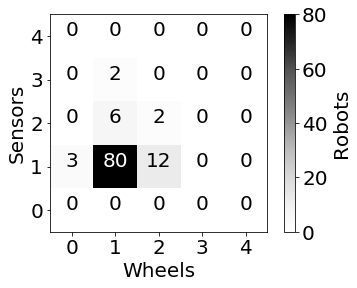

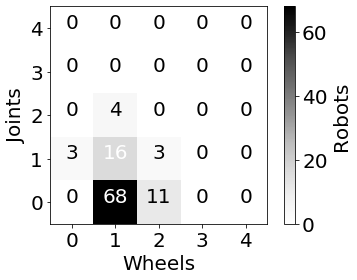

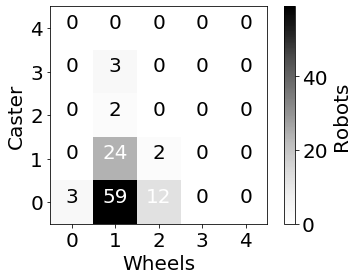

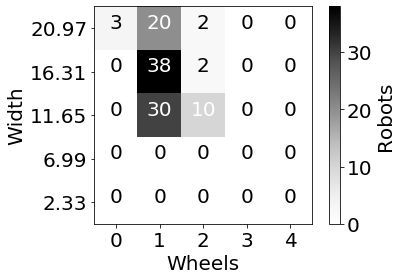

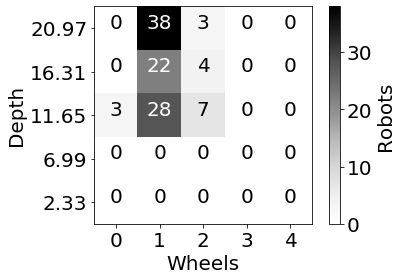

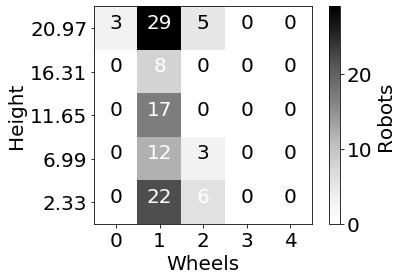

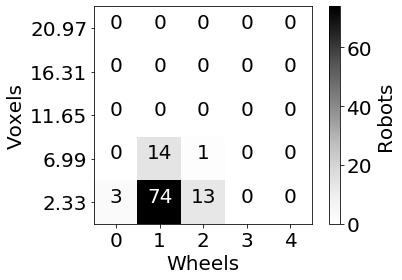

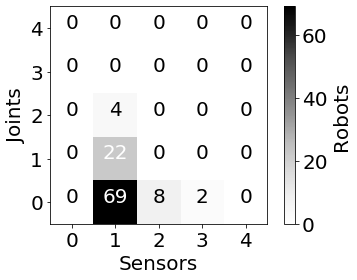

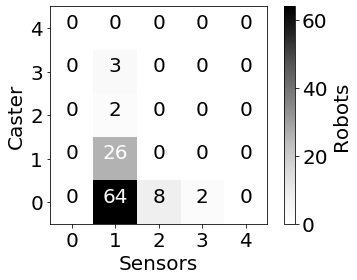

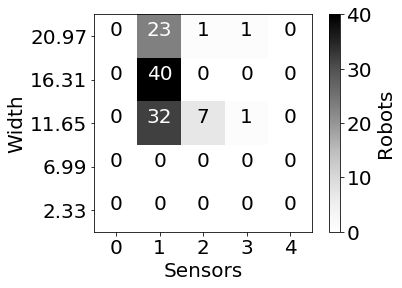

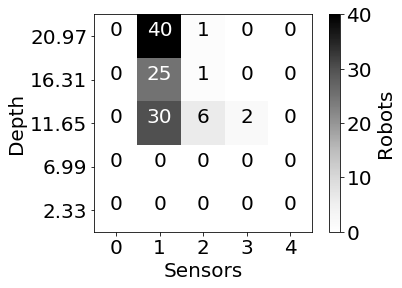

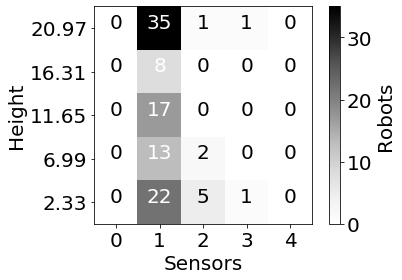

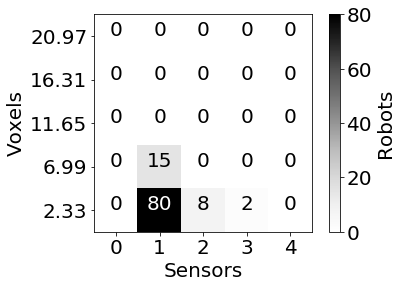

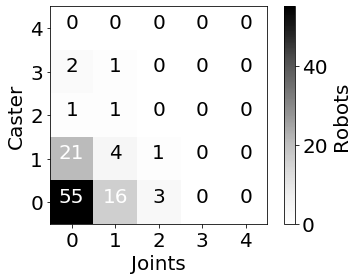

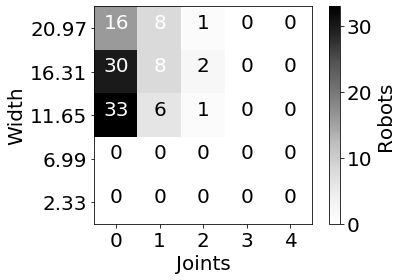

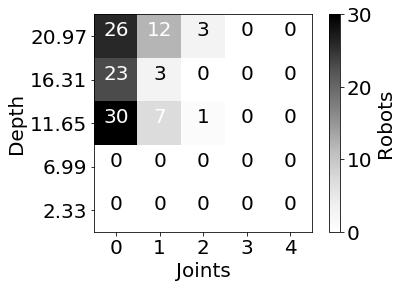

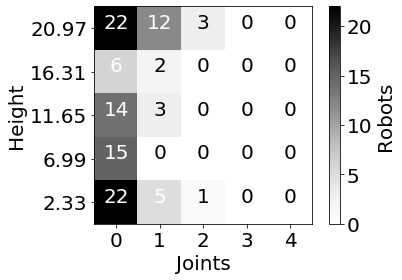

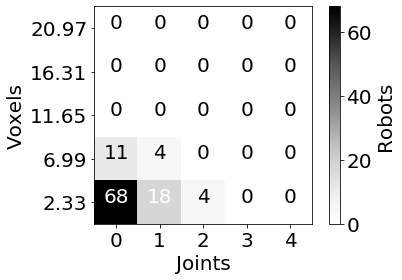

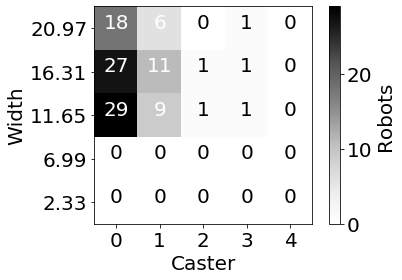

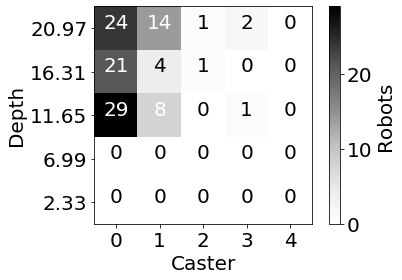

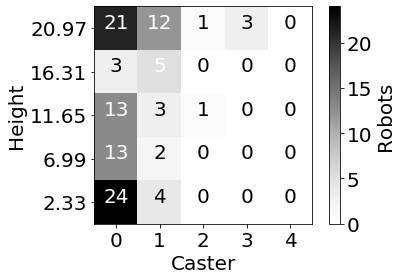

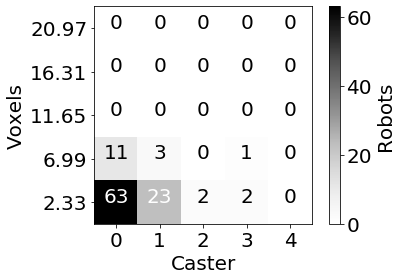

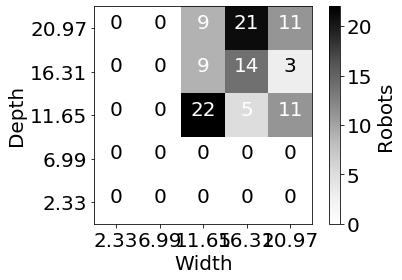

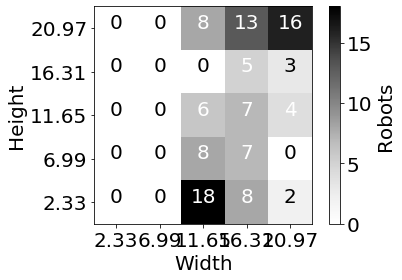

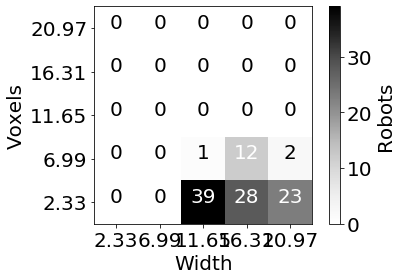

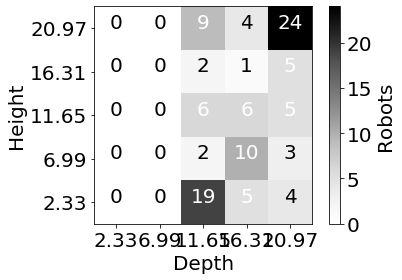

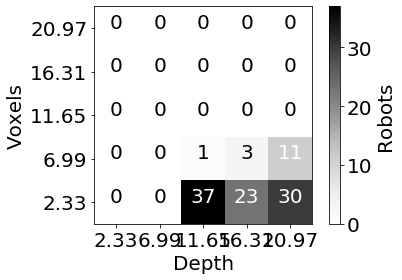

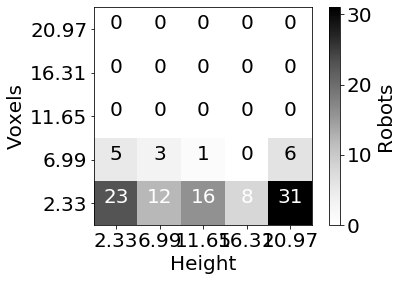

In [72]:
plot_histograms(hist_arena,"arena_095")

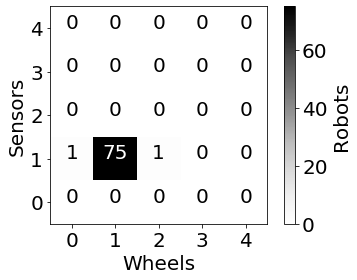

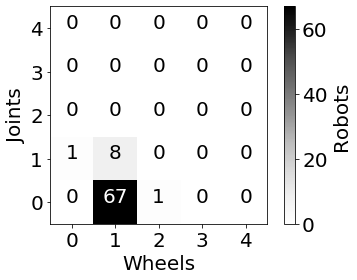

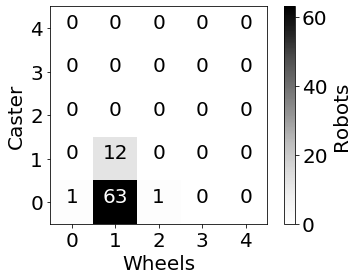

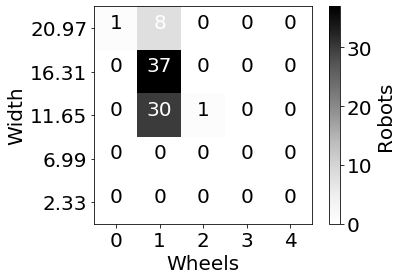

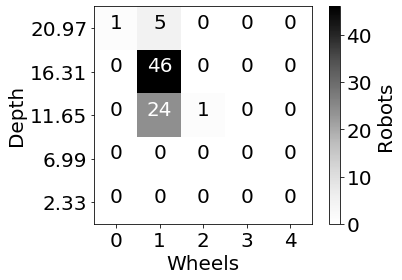

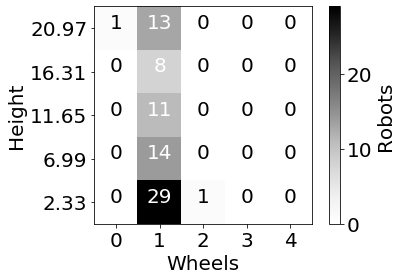

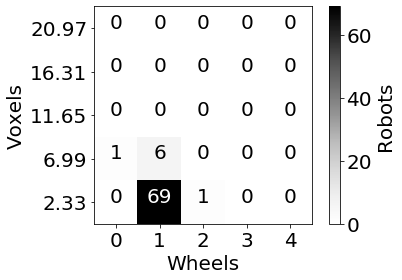

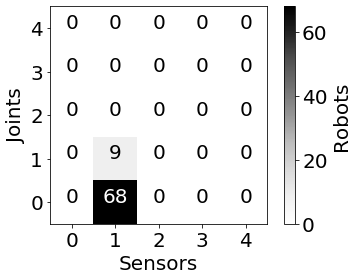

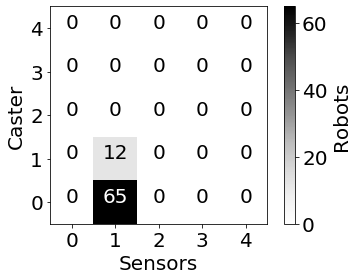

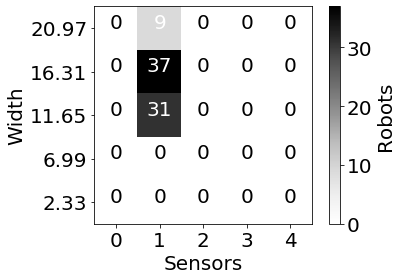

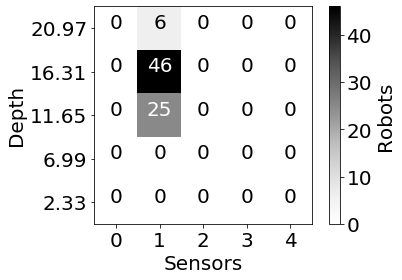

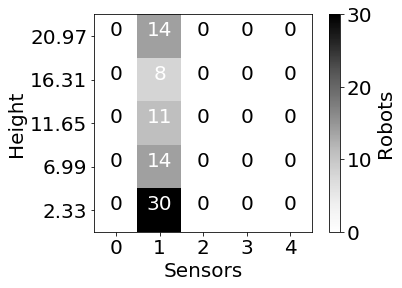

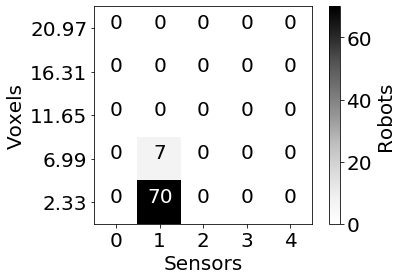

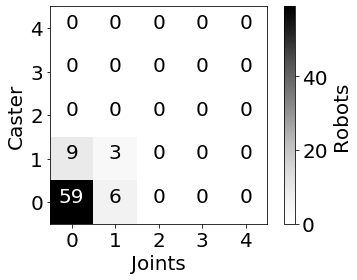

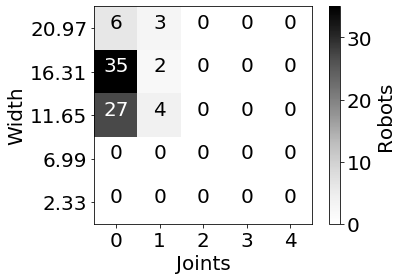

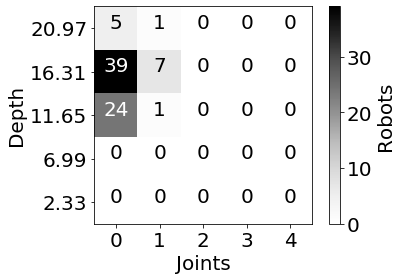

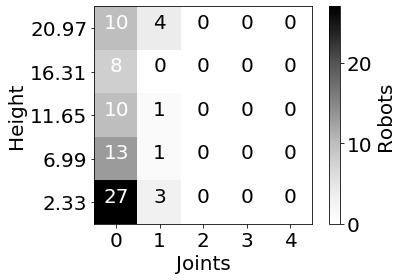

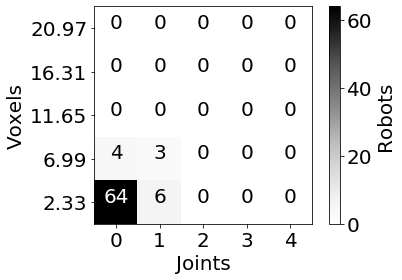

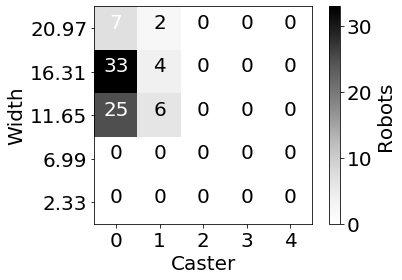

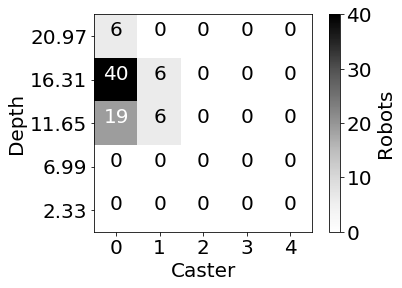

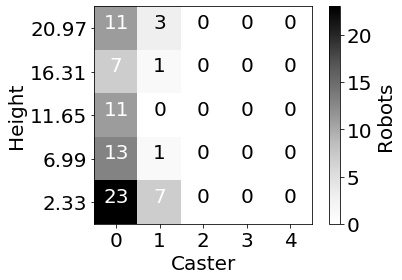

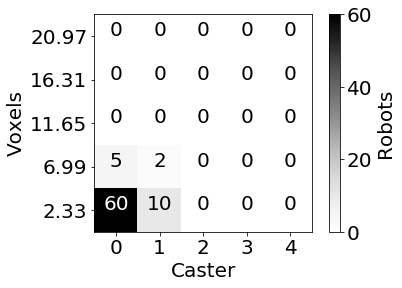

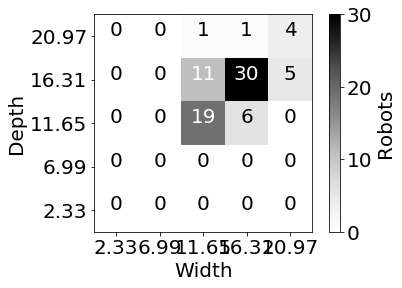

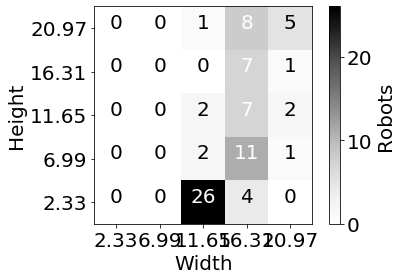

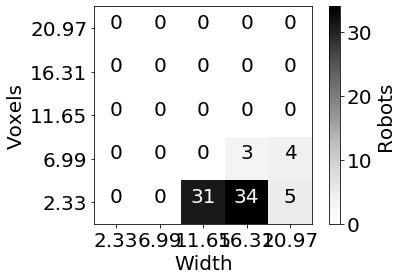

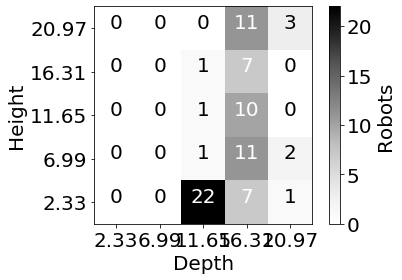

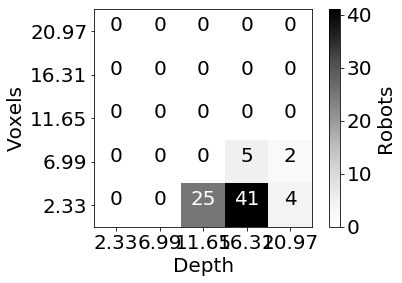

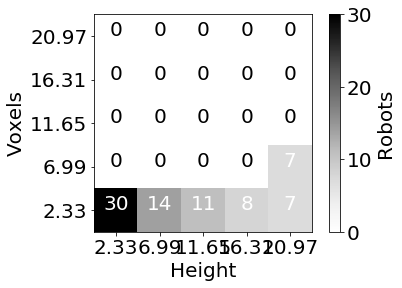

In [73]:
plot_histograms(hist_arena_rand,"arena_095_rand")

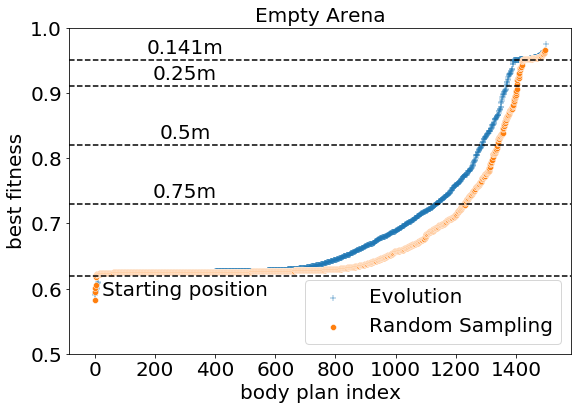

In [74]:
plot_best_fitness("Empty Arena",d_arena,d_arena_rand,0.62)

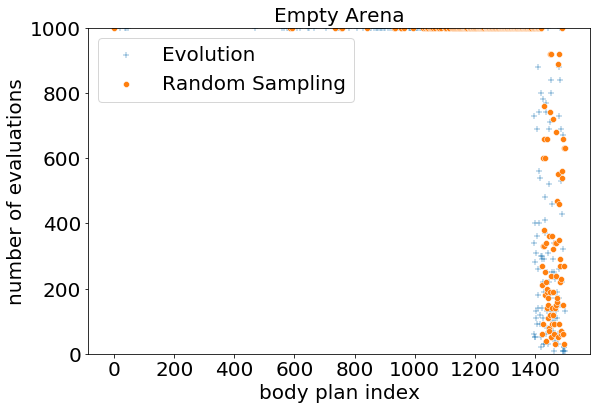

In [22]:
plot_number_eval("Empty Arena",d_arena,d_arena_rand)

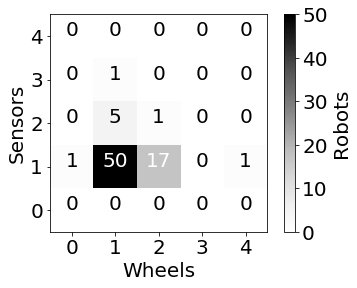

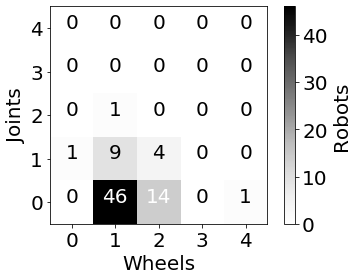

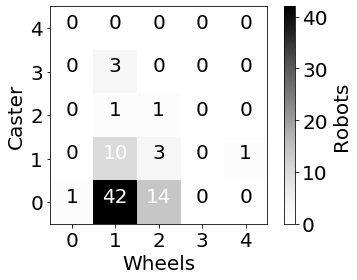

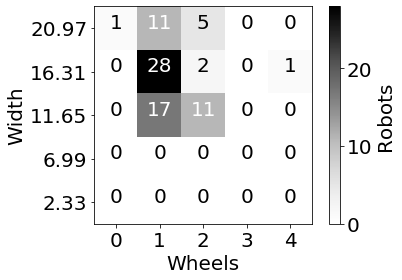

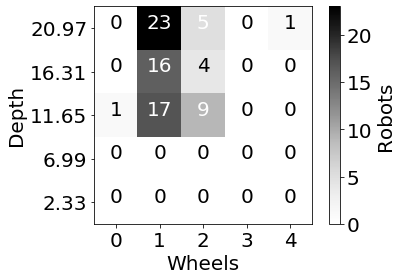

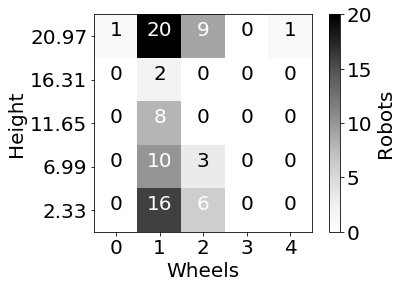

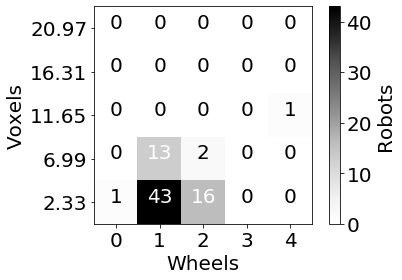

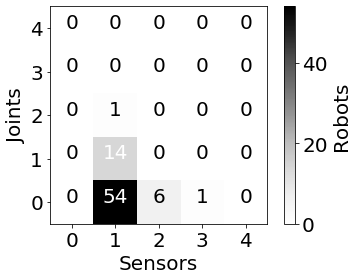

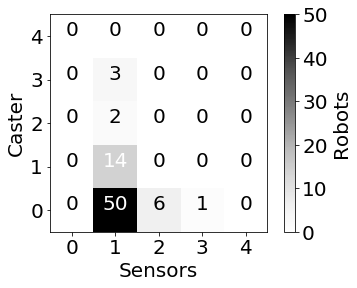

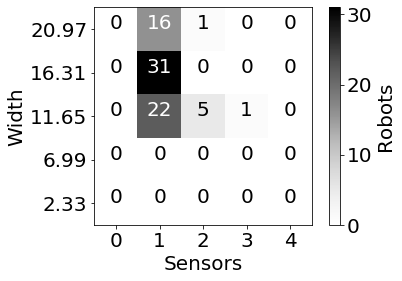

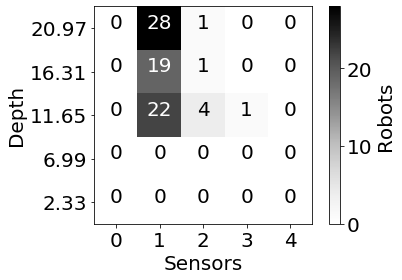

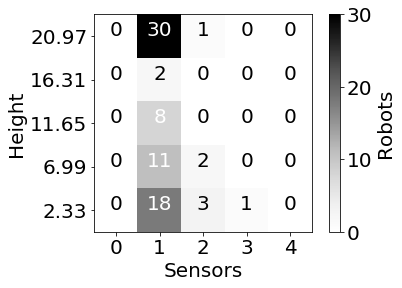

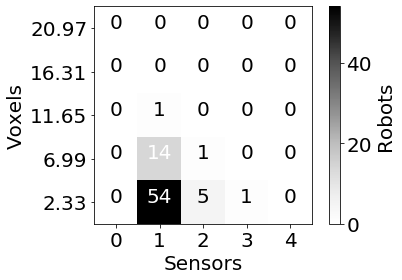

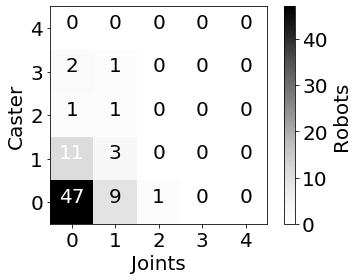

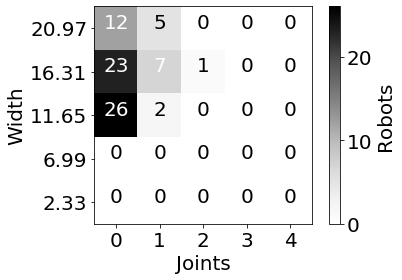

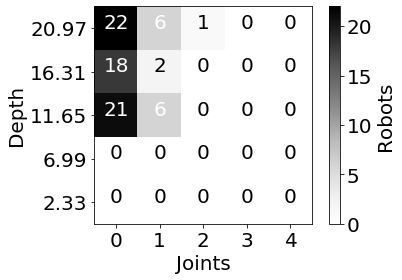

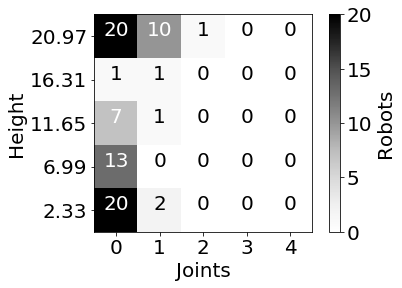

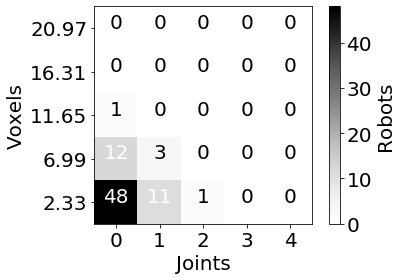

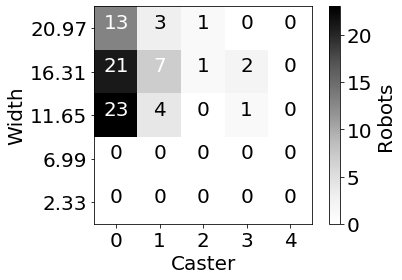

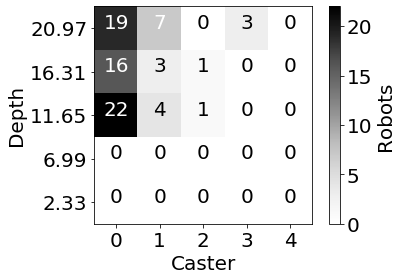

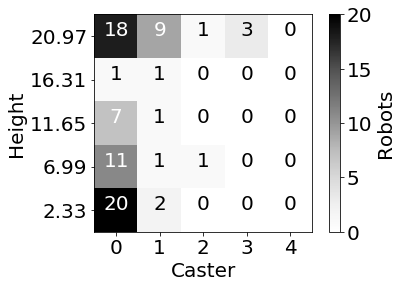

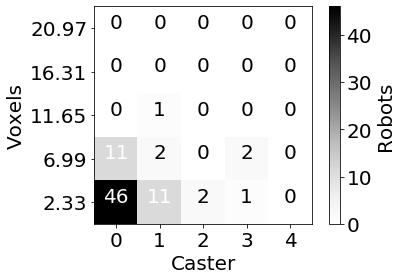

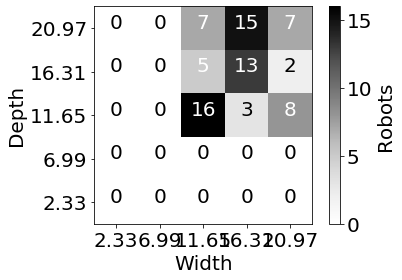

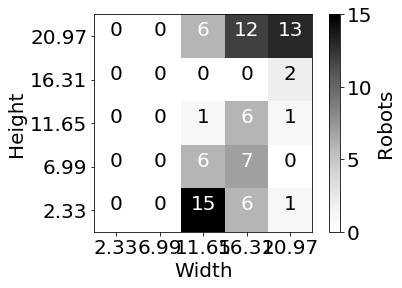

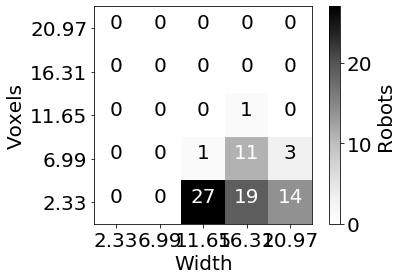

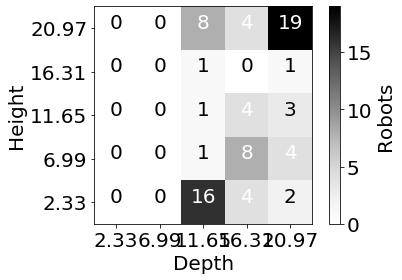

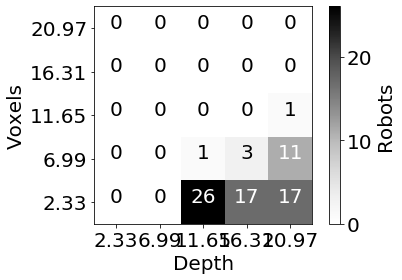

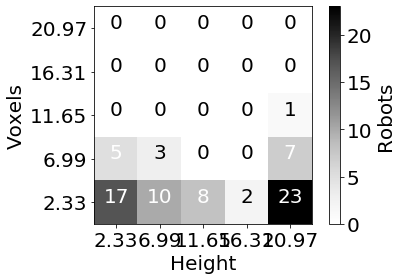

In [77]:
plot_histograms(hist_escape,"escape_095")

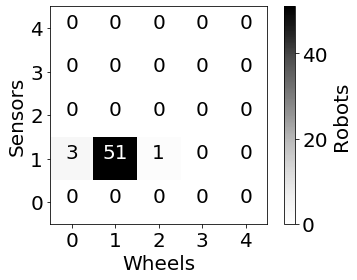

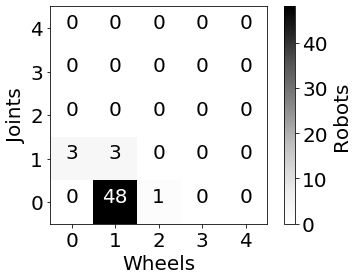

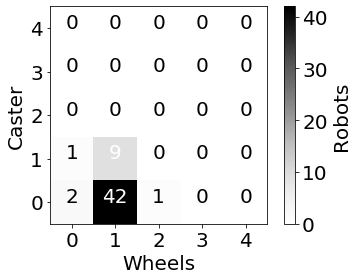

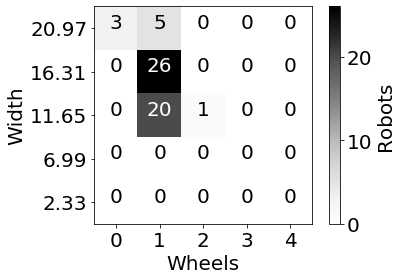

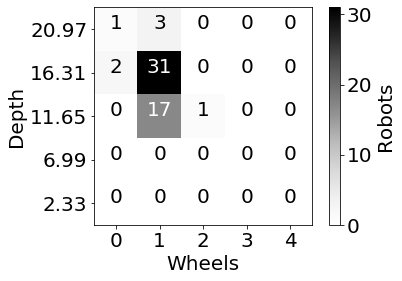

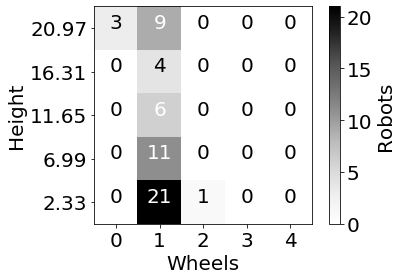

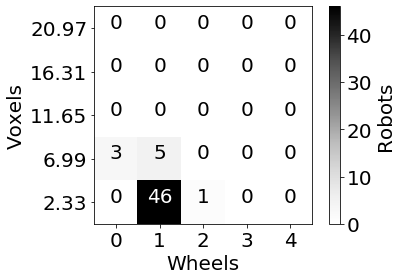

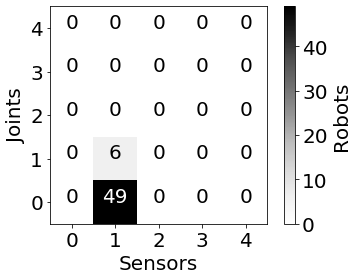

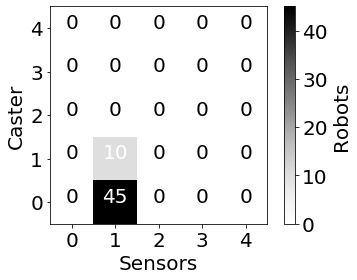

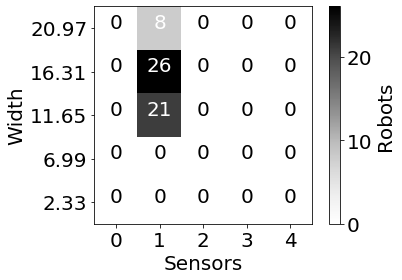

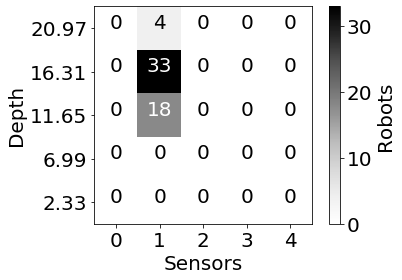

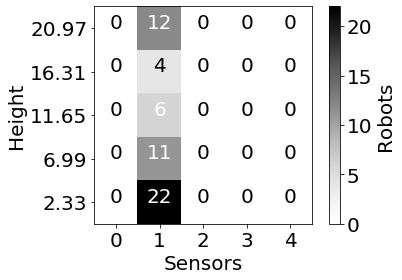

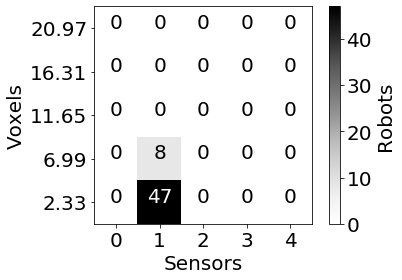

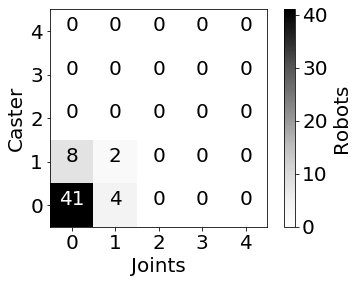

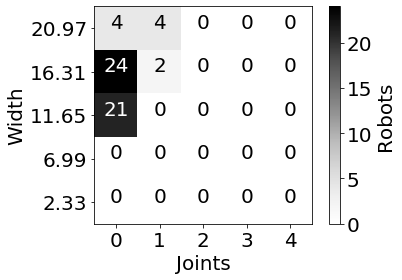

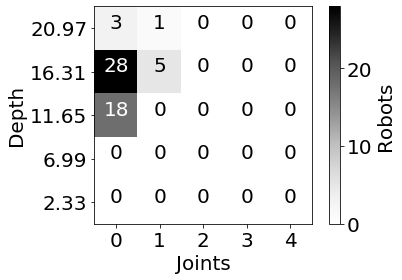

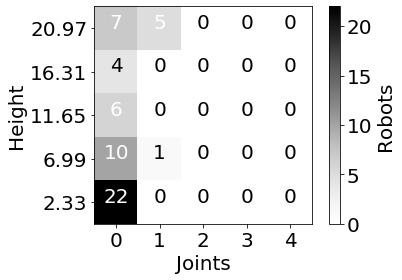

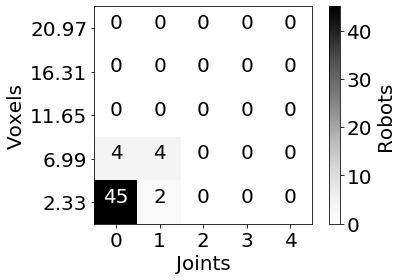

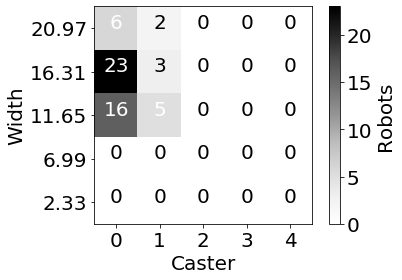

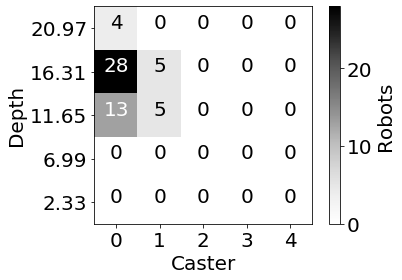

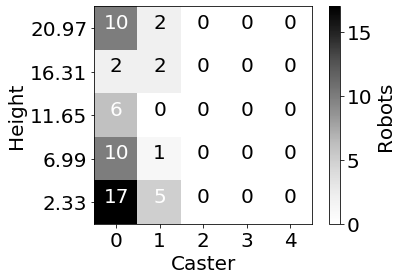

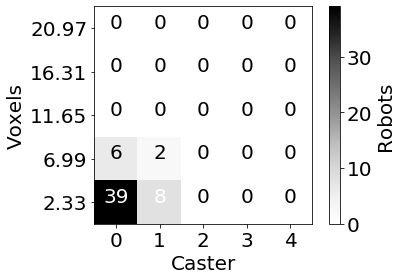

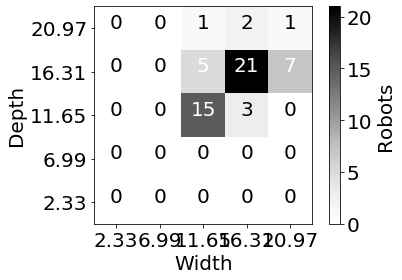

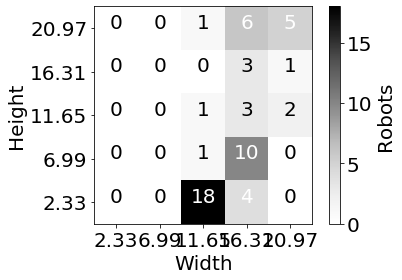

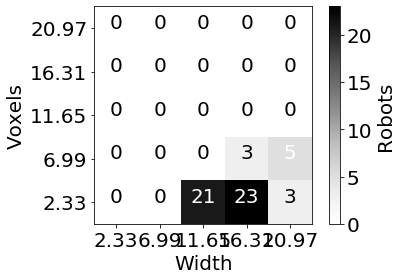

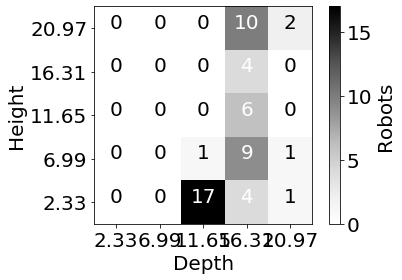

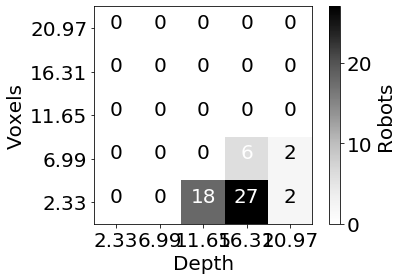

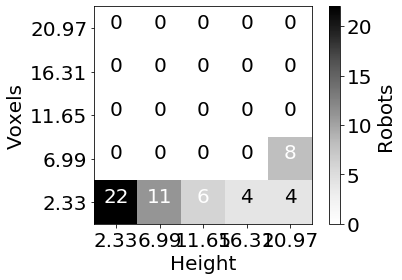

In [78]:
plot_histograms(hist_escape_rand,"escape_095_rand")

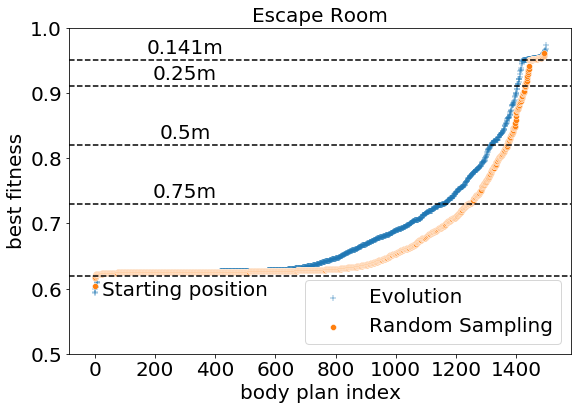

In [79]:
plot_best_fitness("Escape Room",d_escape,d_escape_rand,0.62)

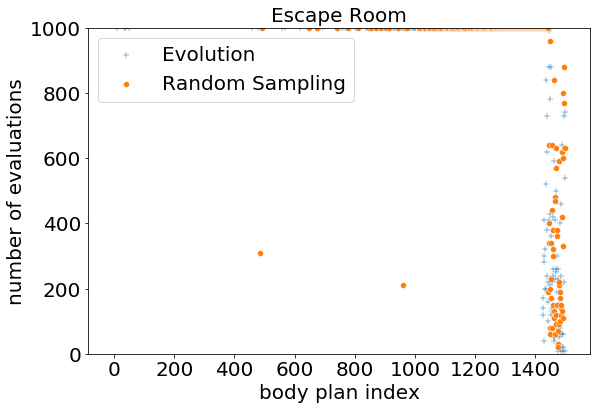

In [23]:
plot_number_eval("Escape Room",d_escape,d_escape_rand)

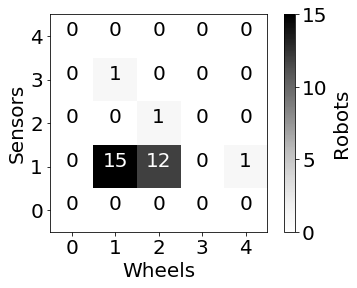

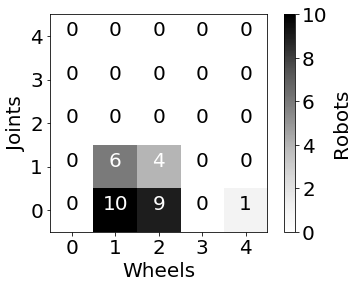

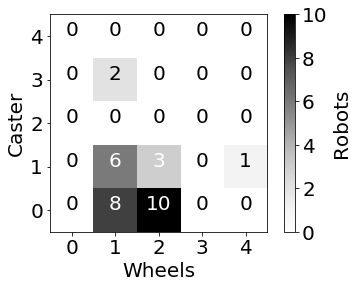

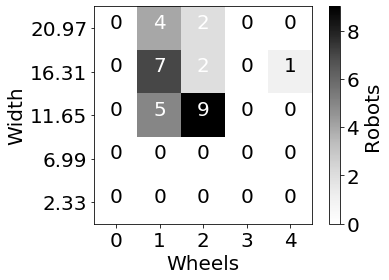

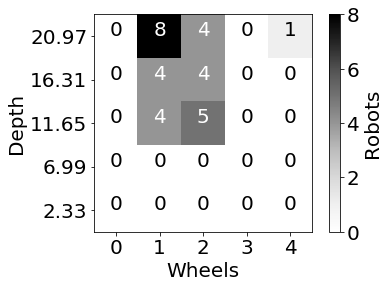

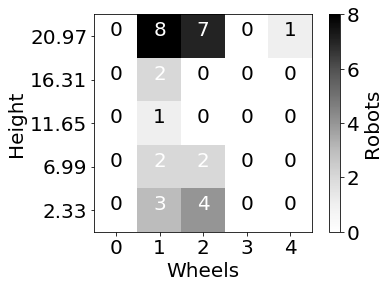

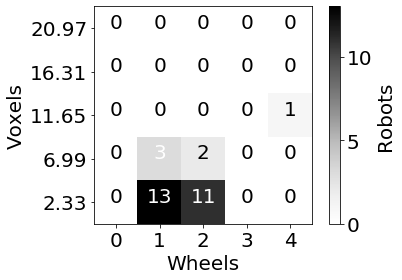

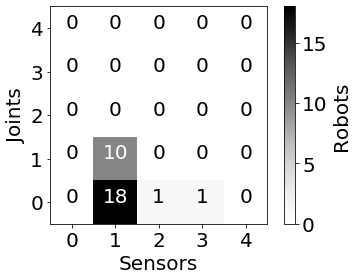

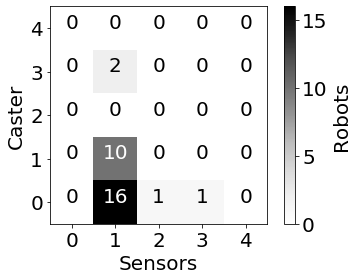

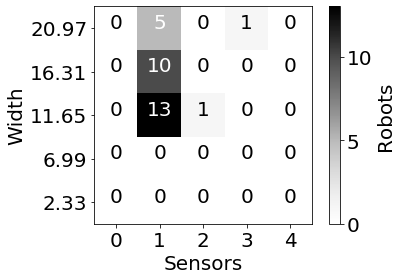

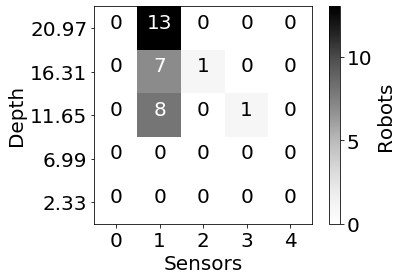

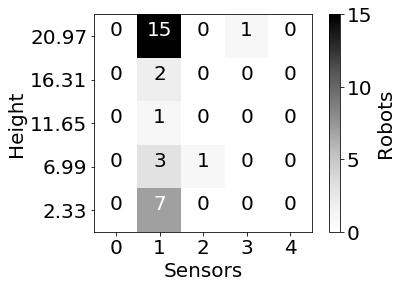

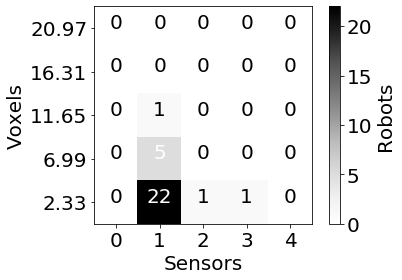

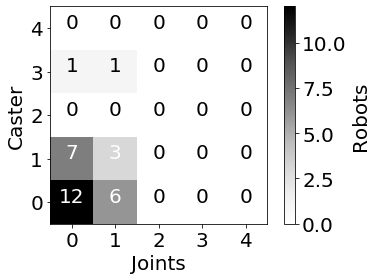

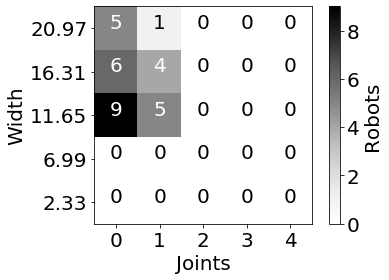

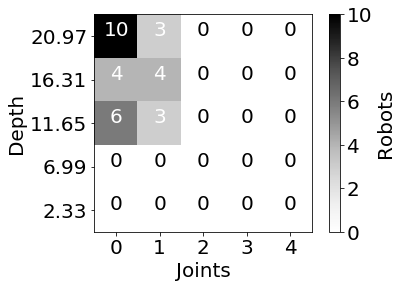

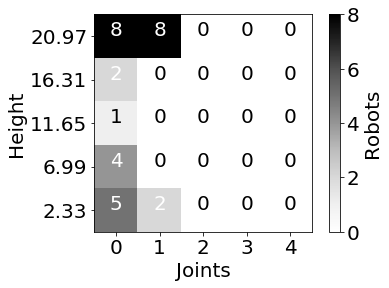

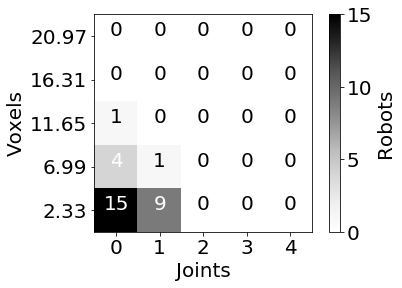

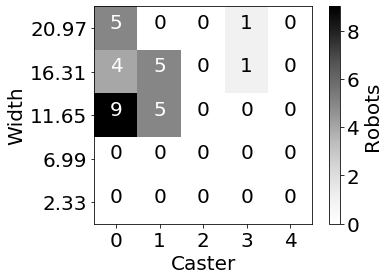

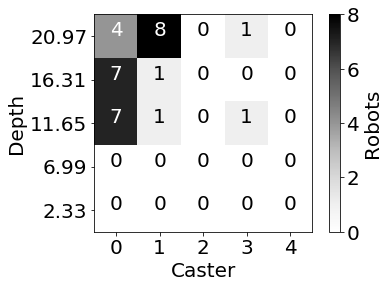

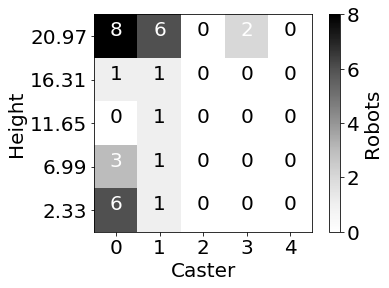

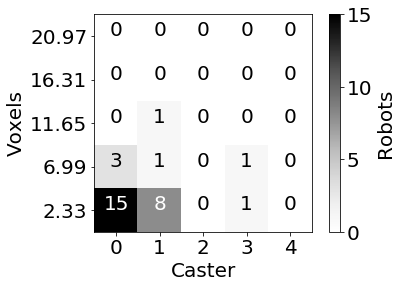

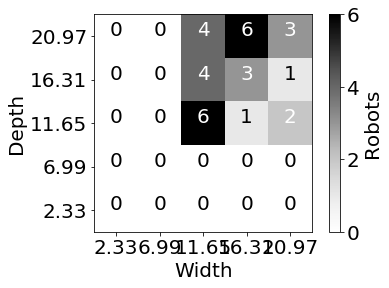

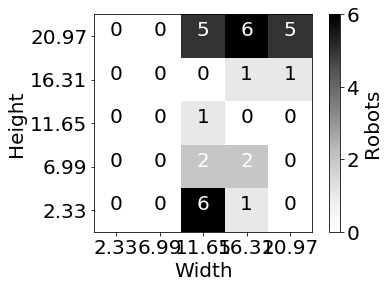

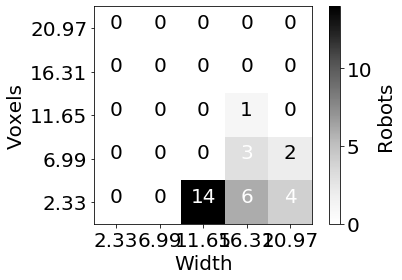

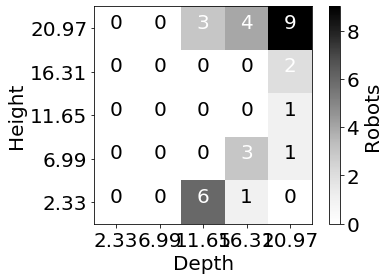

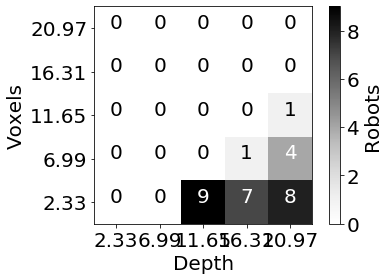

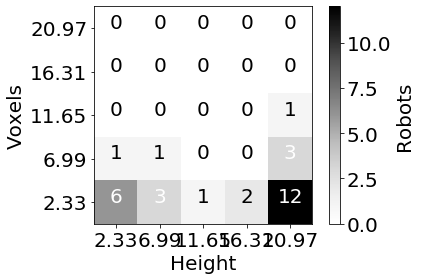

In [80]:
plot_histograms(hist_middle,"middle_095")

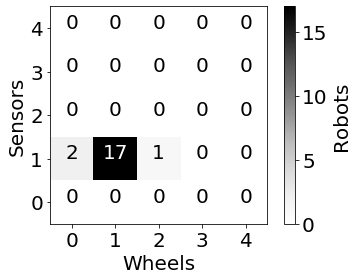

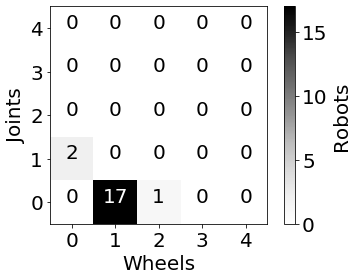

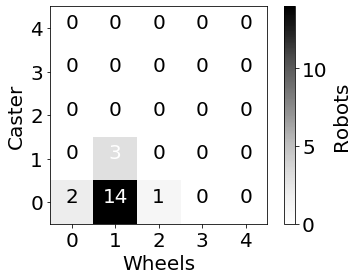

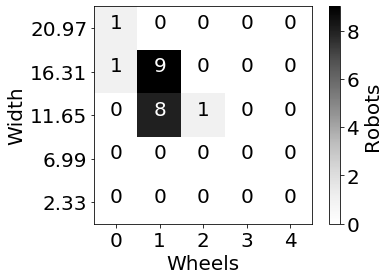

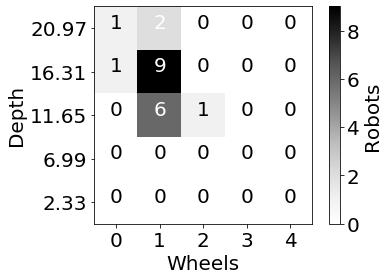

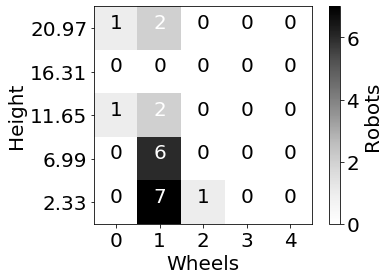

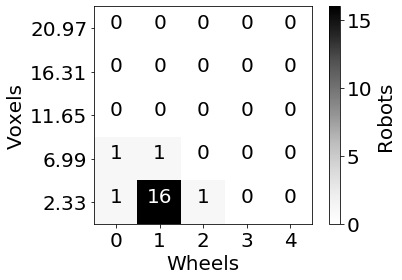

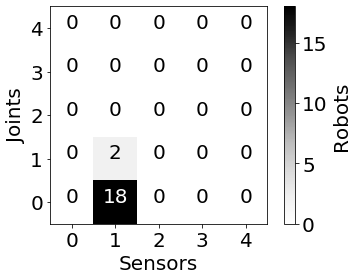

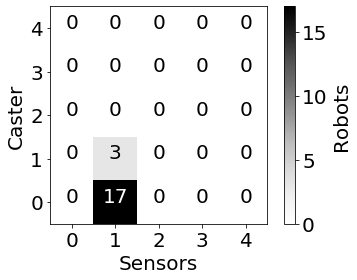

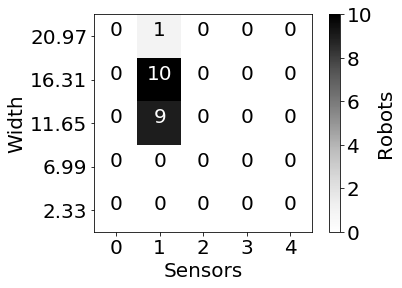

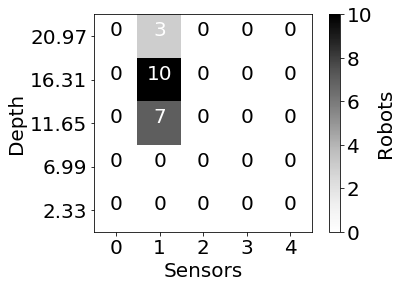

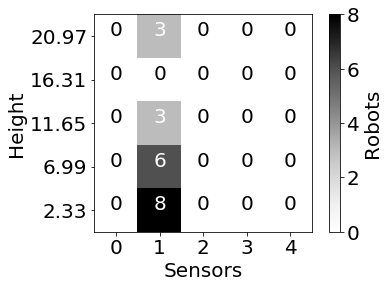

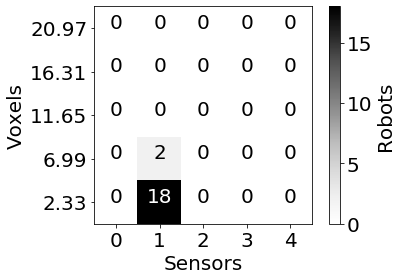

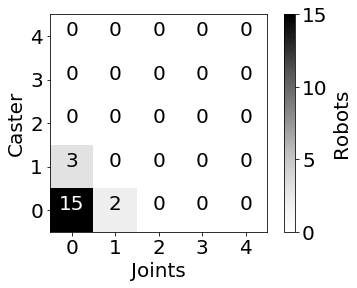

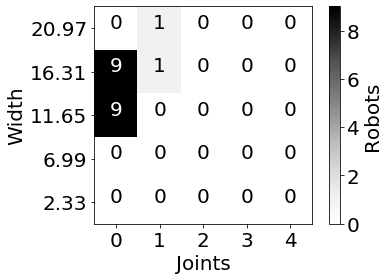

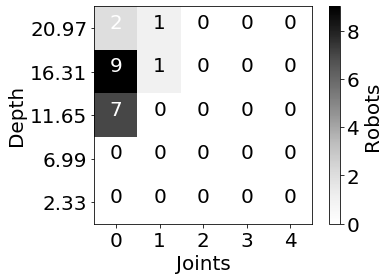

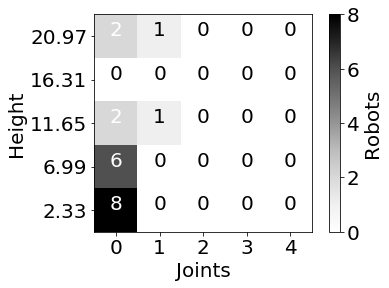

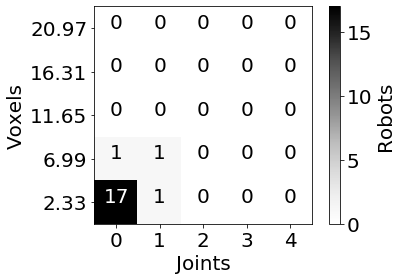

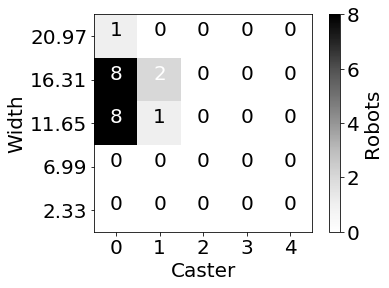

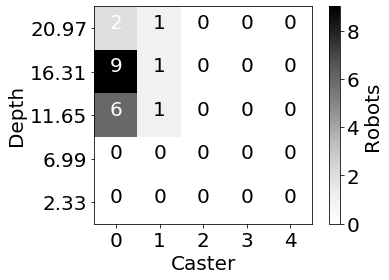

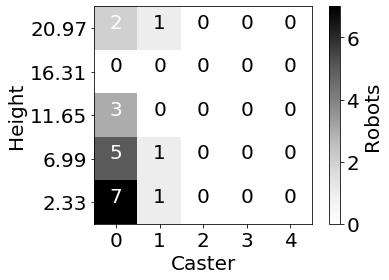

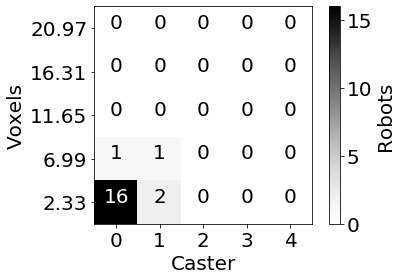

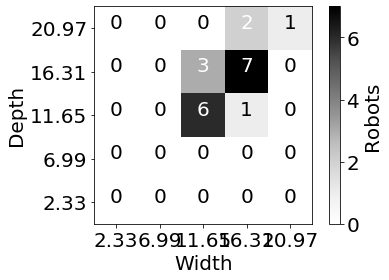

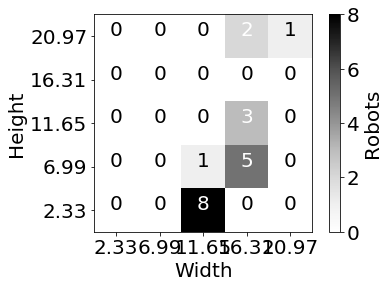

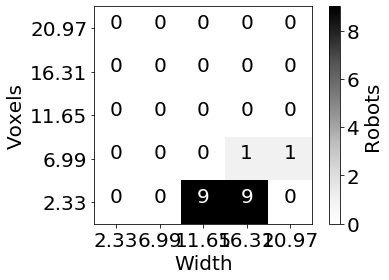

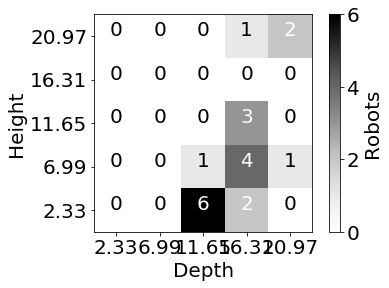

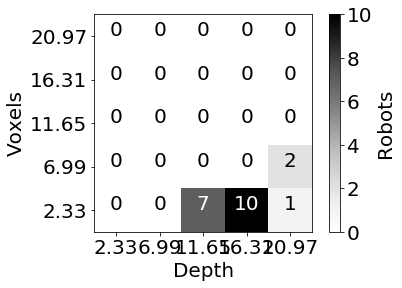

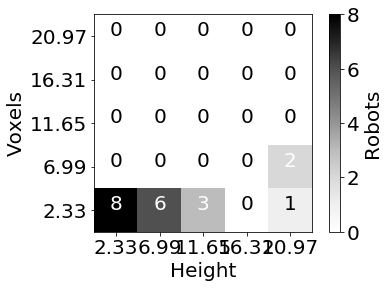

In [81]:
plot_histograms(hist_middle_rand,"middle_095_rand")

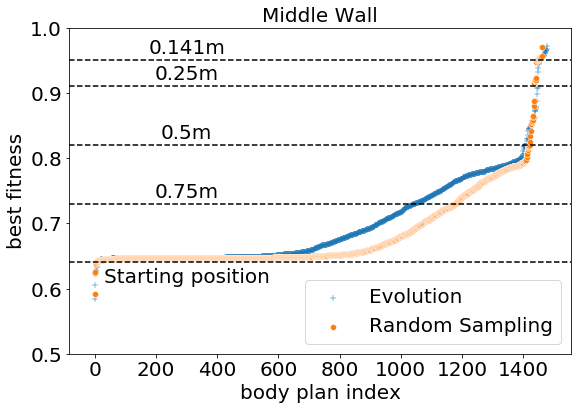

In [82]:
plot_best_fitness("Middle Wall",d_middle,d_middle_rand,0.64)

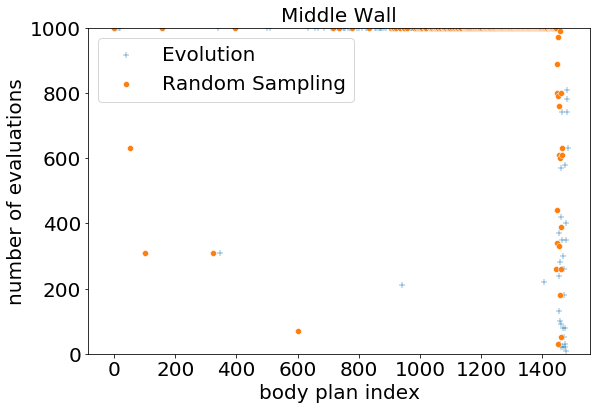

In [24]:
plot_number_eval("Middle Wall",d_middle,d_middle_rand)

In [83]:
hist_arena, hist_all_arena, d_arena = compute_dataframe("/home/leni/are-logs/pmn_arena_20200929/","traitDescriptor",100)
hist_arena_rand, hist_all_arena_rand, d_arena_rand = compute_dataframe("/home/leni/are-logs/pmn_arena_20200929_rand/","randomSampling",100)
hist_escape, hist_all_escape, d_escape = compute_dataframe("/home/leni/are-logs/pmn_escape_20200929/","traitDescriptor",100)
hist_escape_rand, hist_all_escape_rand, d_escape_rand = compute_dataframe("/home/leni/are-logs/pmn_escape_20200929_rand/","randomSampling",100)
hist_middle, hist_all_middle, d_middle = compute_dataframe("/home/leni/are-logs/pmn_middle_20200929/","traitDescriptor",100)
hist_middle_rand, hist_all_middle_rand, d_middle_rand = compute_dataframe("/home/leni/are-logs/pmn_middle_20200929_rand/","randomSampling",100)

0.95 1.0 1.4696938456699071 0.91 3.0 1.4544949486180951 0.82 5.0 2.703084657695106 0.73 13.0 3.4807406619217636
1500 1500
0.95 1.0 0.8326663997864531 0.91 2.0 1.1661903789690602 0.82 4.0 1.6679994670929073 0.73 10.0 1.8903262505010434
1499 1499
0.95 1.0 0.9285592184789413 0.91 1.0 1.2036980056845192 0.82 4.0 2.0483055327649624 0.73 12.0 2.8859814429217816
1500 1500
0.95 1.0 0.699205898780101 0.91 1.0 0.8537498983243798 0.82 2.0 1.0456258094238748 0.73 9.0 2.3626726862225804
1498 1498
0.95 1.0 0.8537498983243799 0.91 1.0 0.8537498983243799 0.82 1.0 1.7435595774162693 0.73 15.0 4.48503685108111
1483 1483
0.95 0.0 0.33993463423951903 0.91 0.0 0.33993463423951903 0.82 0.0 0.7118052168020875 0.73 11.0 2.9769484749021475
1465 1465


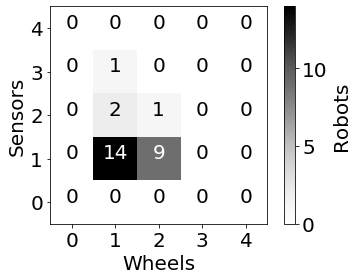

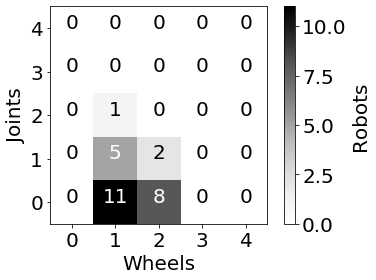

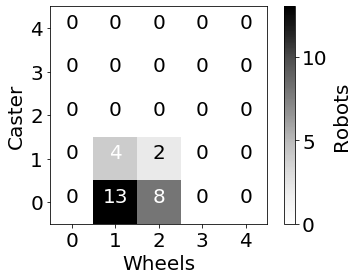

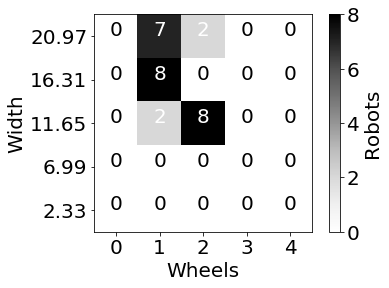

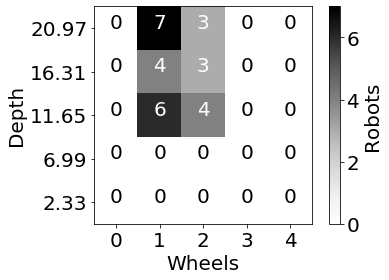

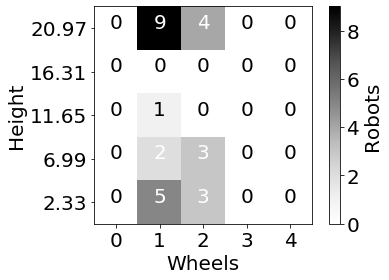

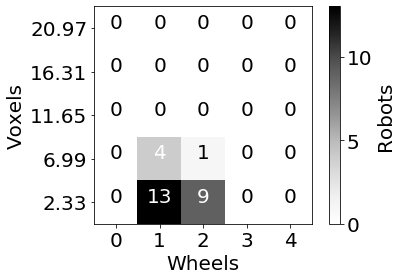

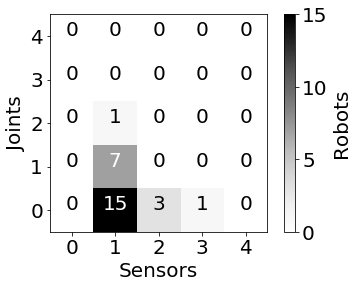

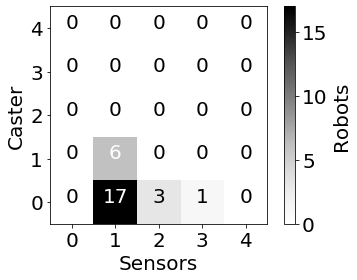

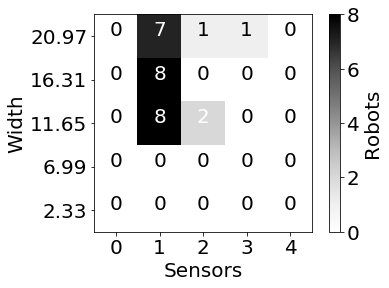

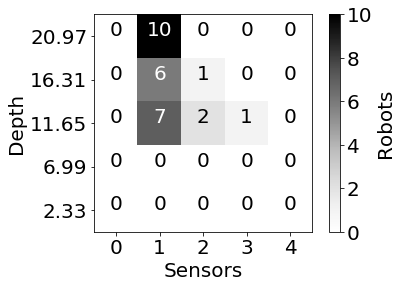

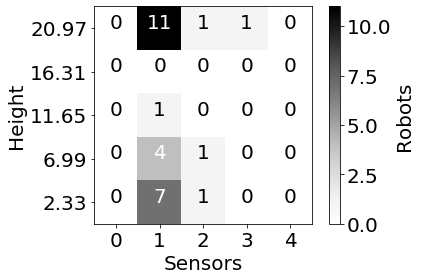

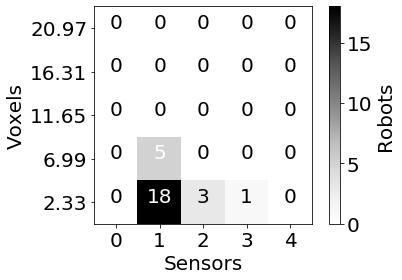

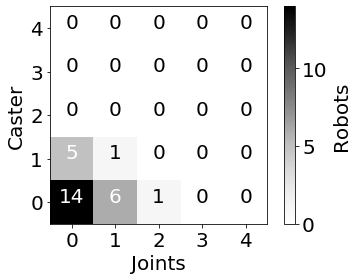

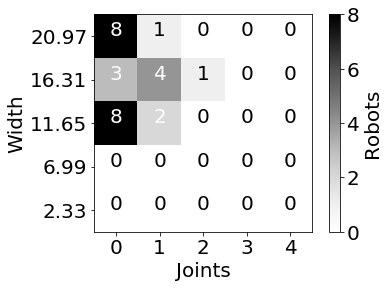

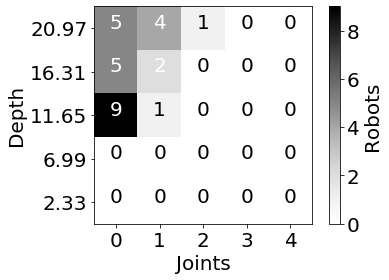

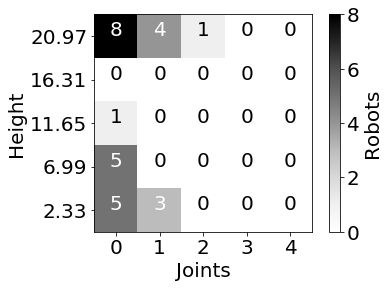

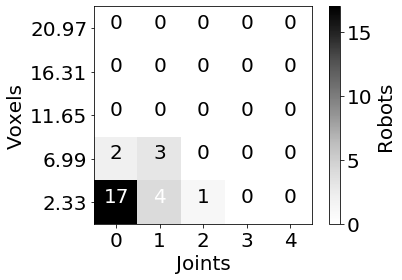

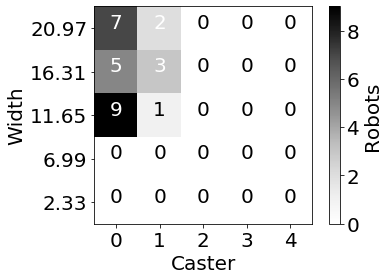

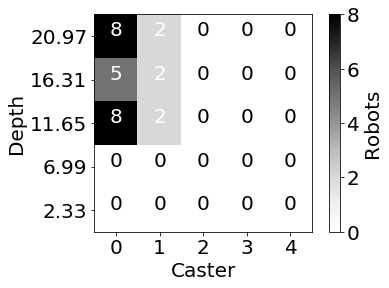

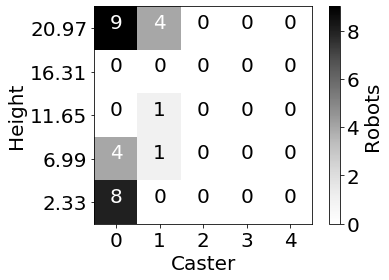

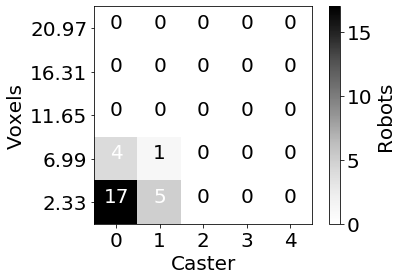

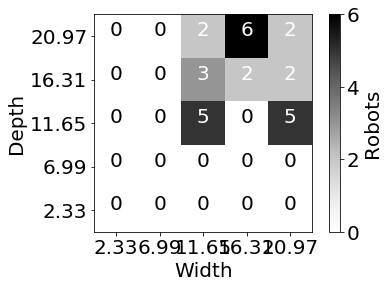

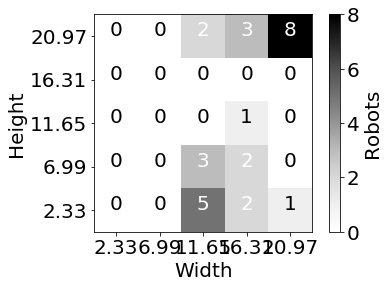

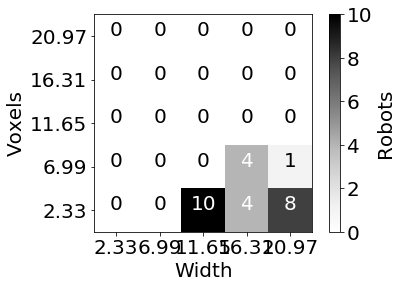

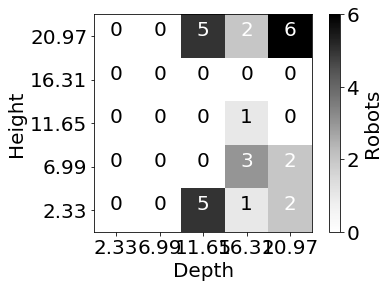

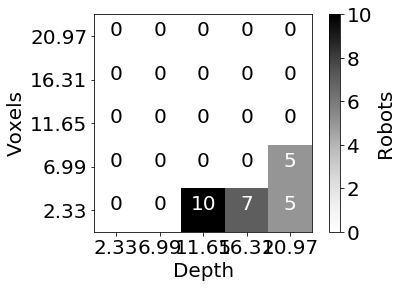

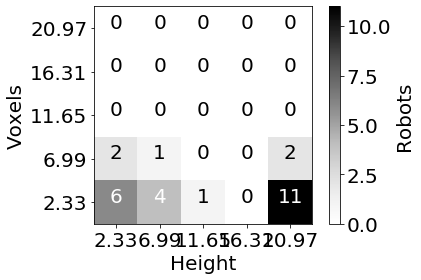

In [84]:
plot_histograms(hist_arena,"arena_095_100")

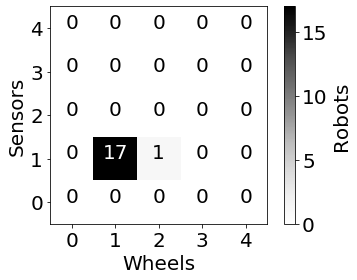

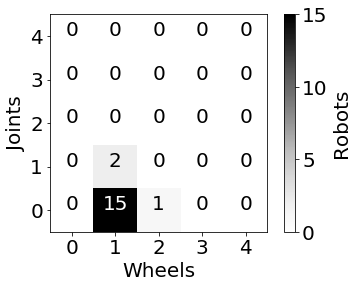

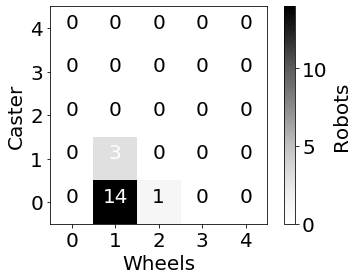

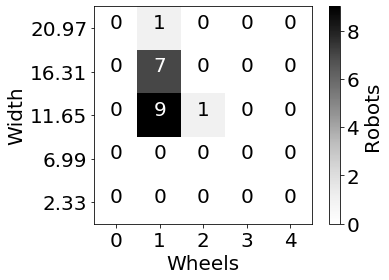

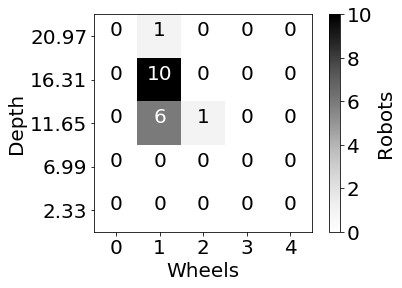

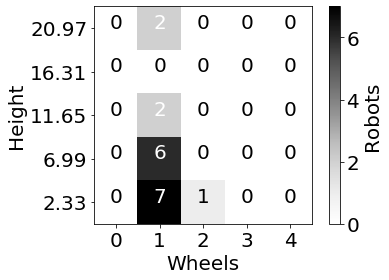

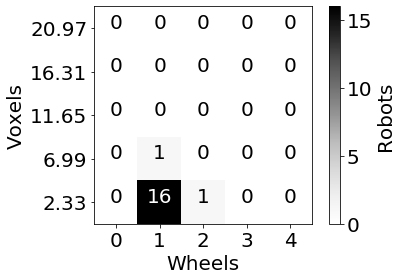

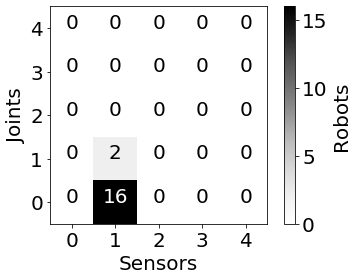

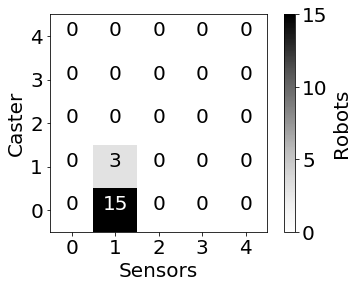

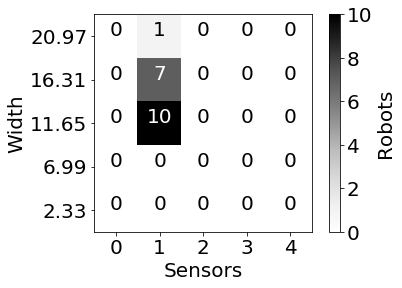

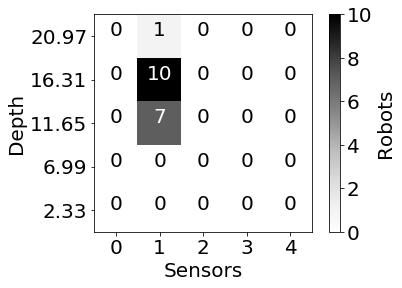

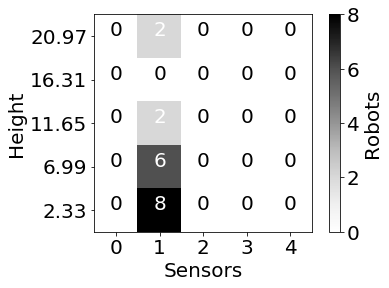

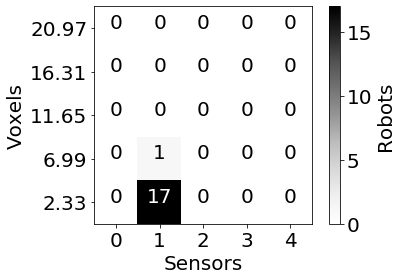

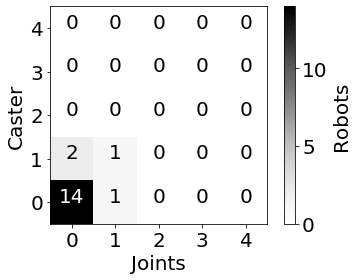

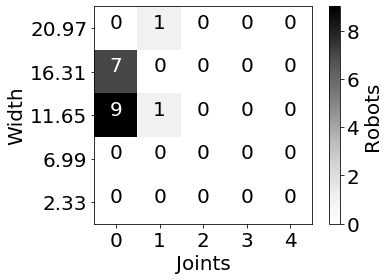

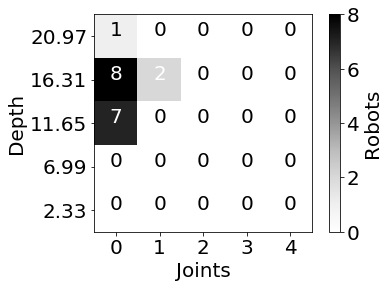

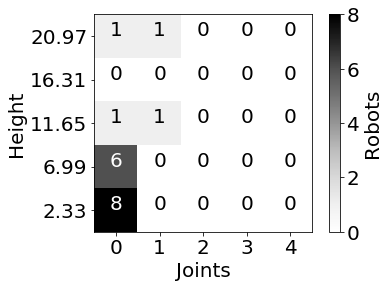

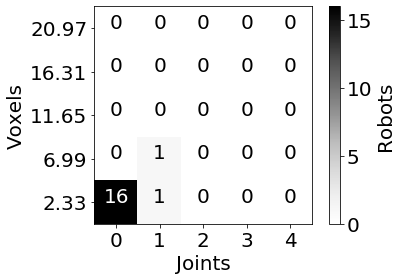

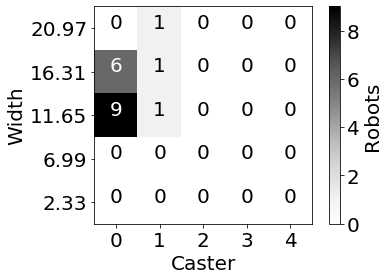

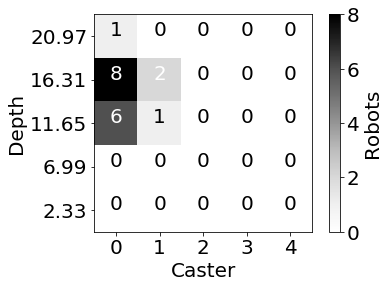

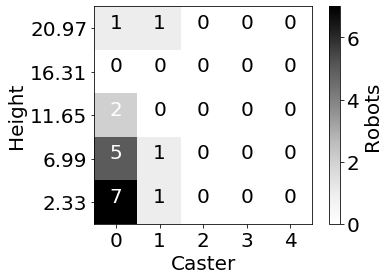

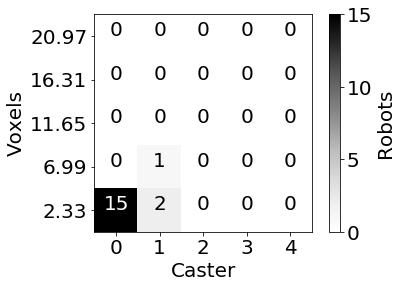

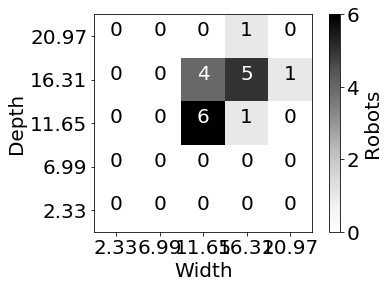

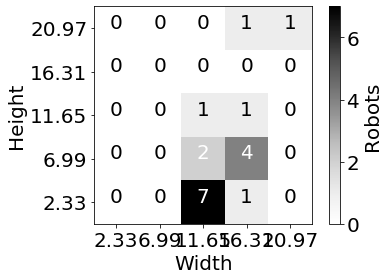

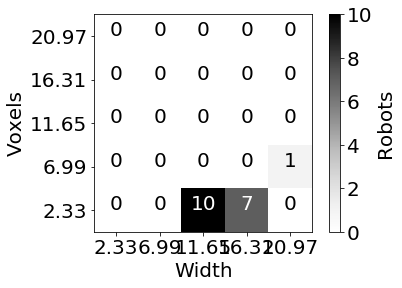

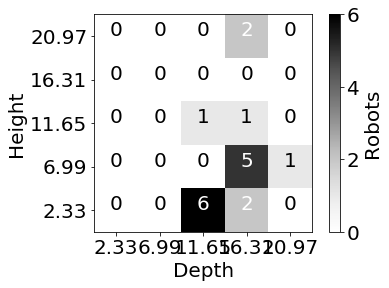

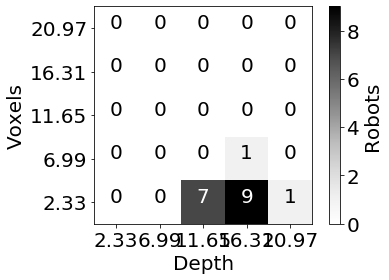

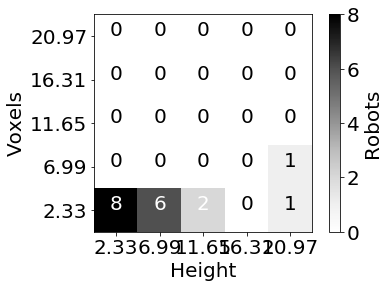

In [85]:
plot_histograms(hist_arena_rand,"arena_095_rand_100")

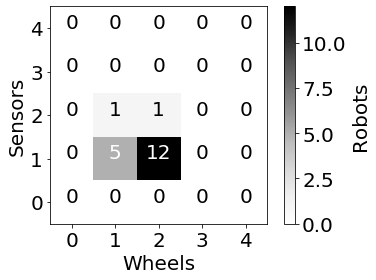

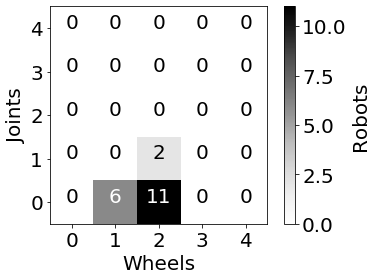

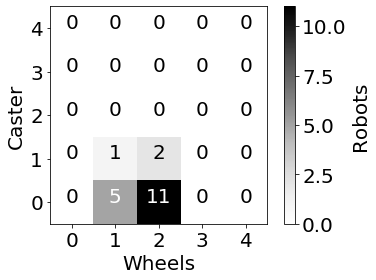

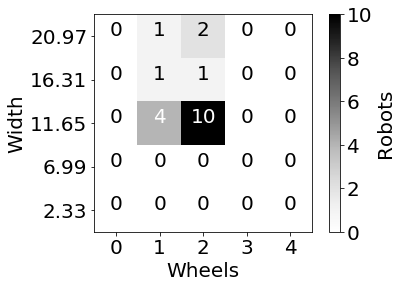

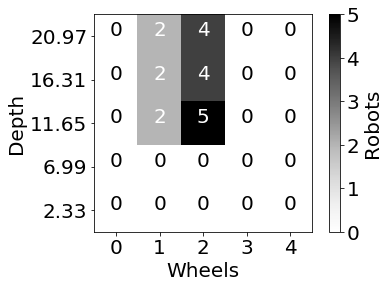

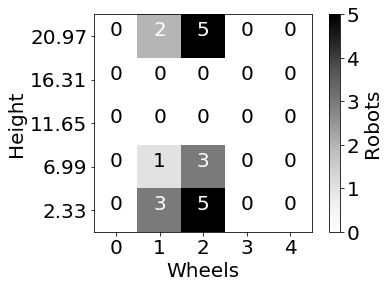

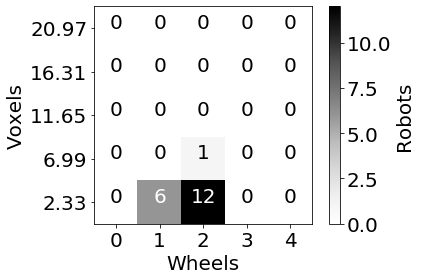

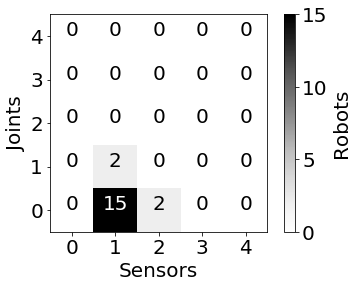

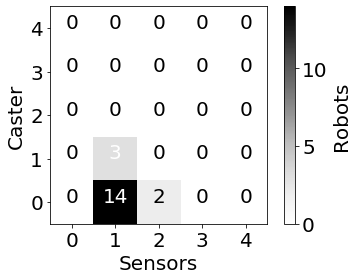

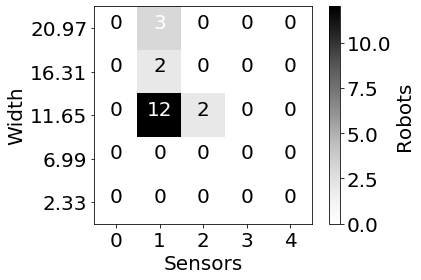

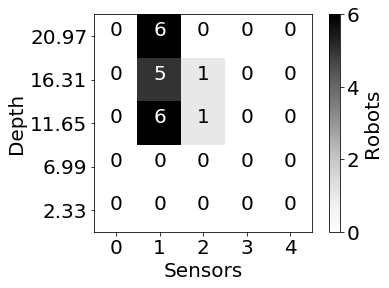

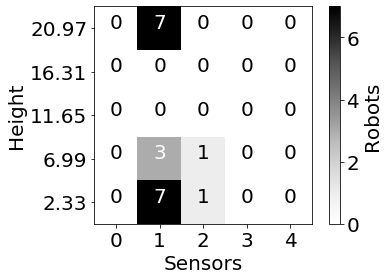

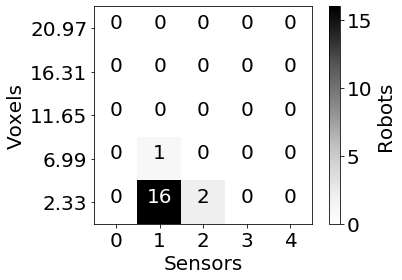

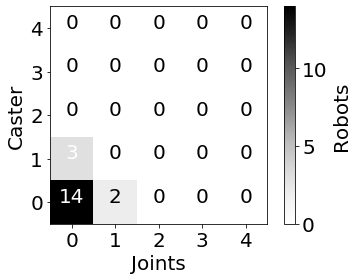

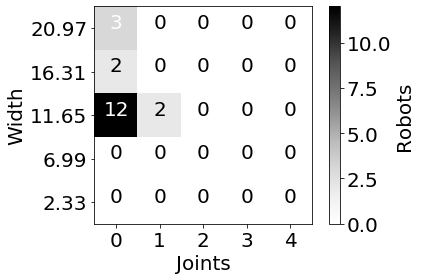

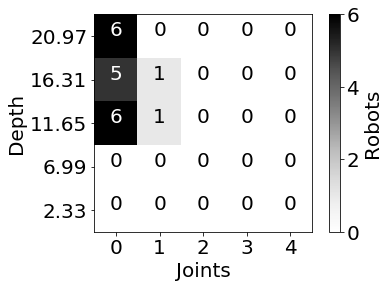

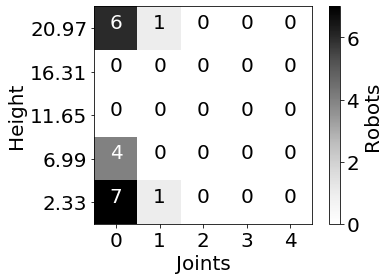

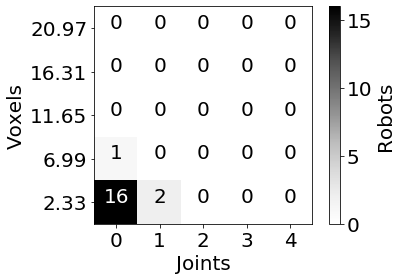

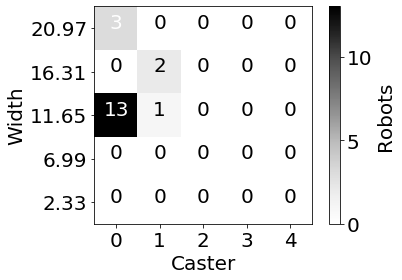

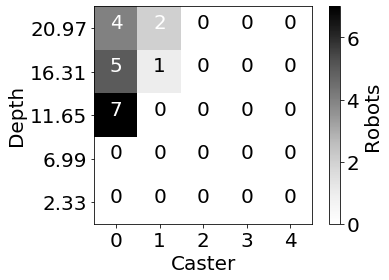

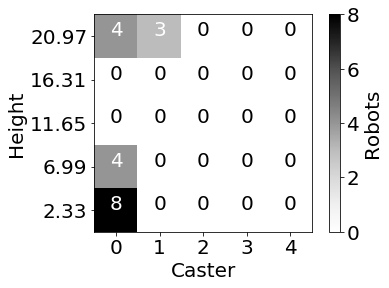

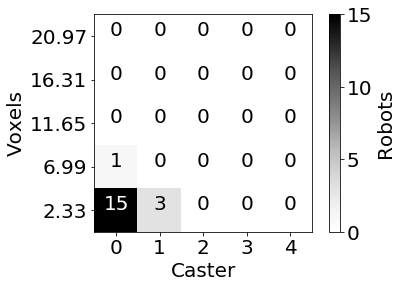

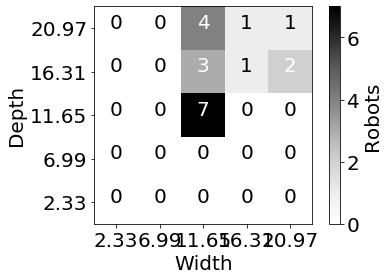

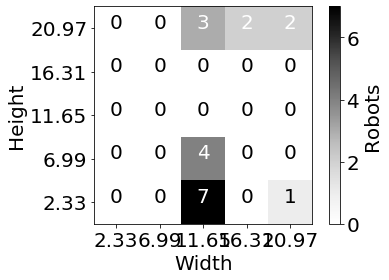

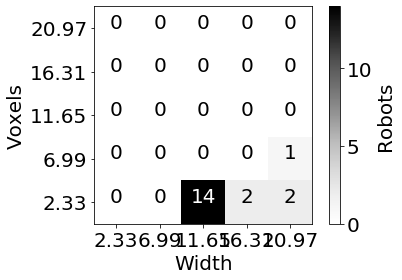

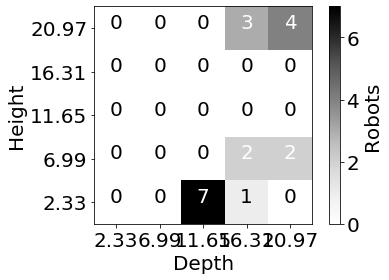

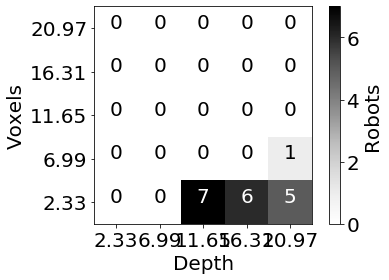

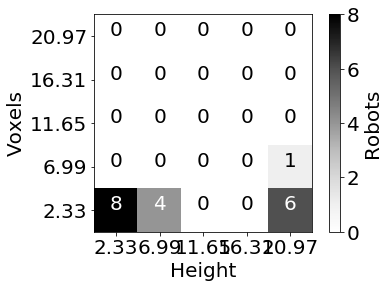

In [86]:
plot_histograms(hist_escape,"escape_095_100")

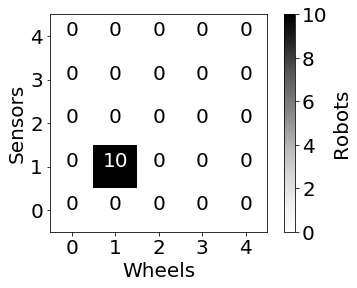

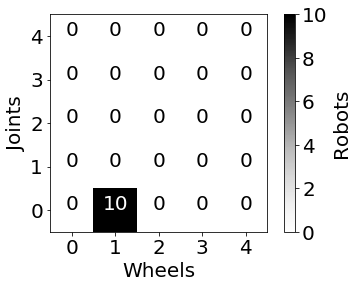

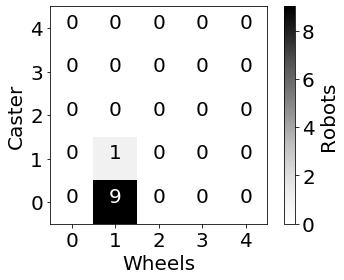

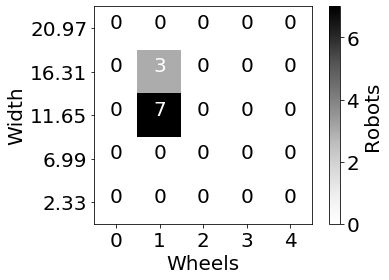

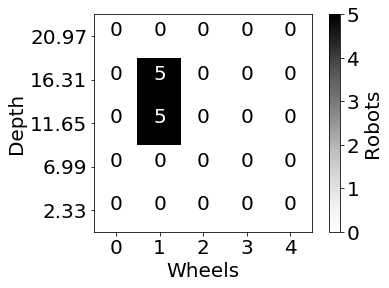

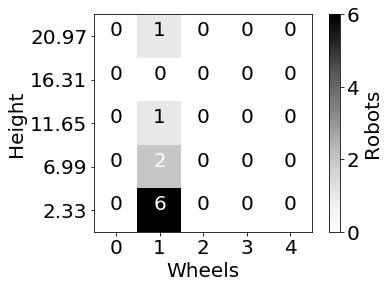

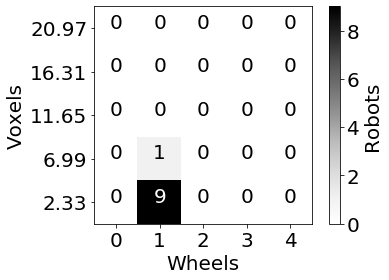

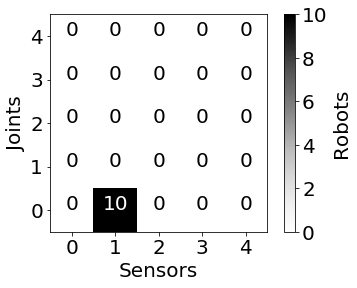

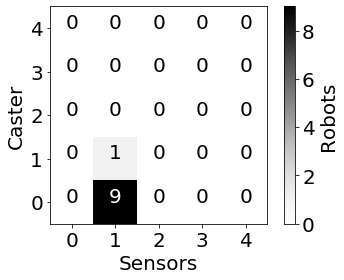

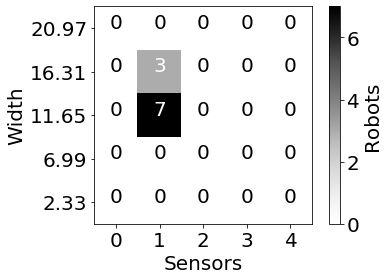

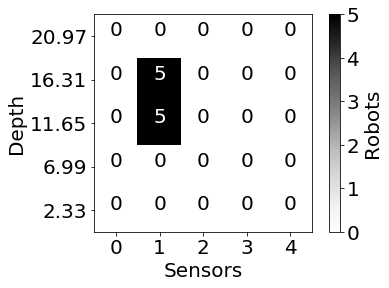

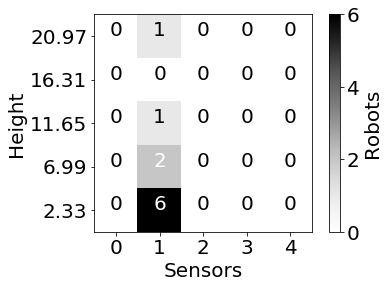

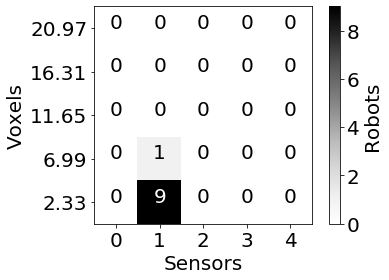

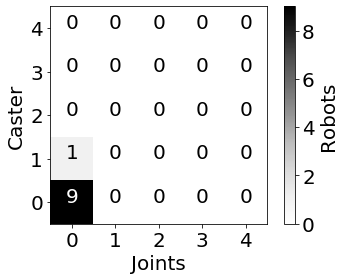

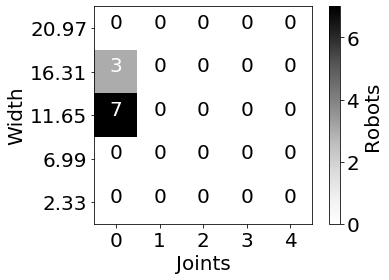

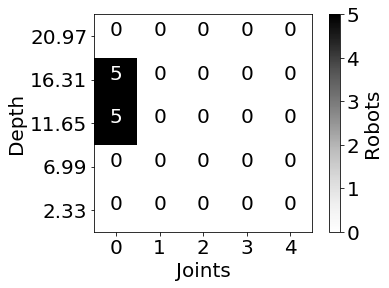

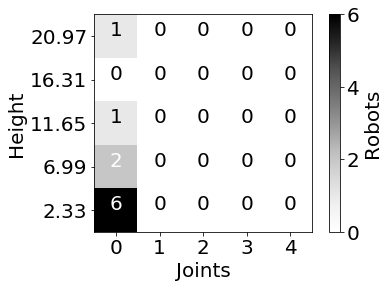

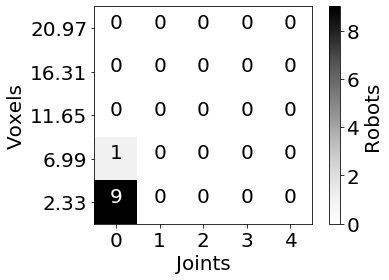

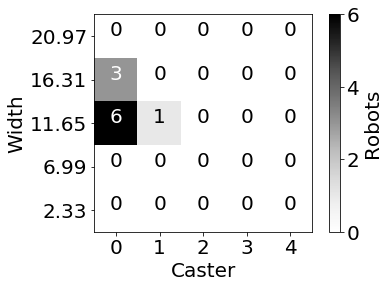

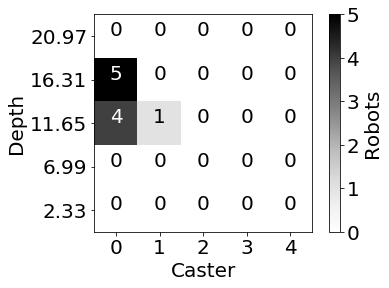

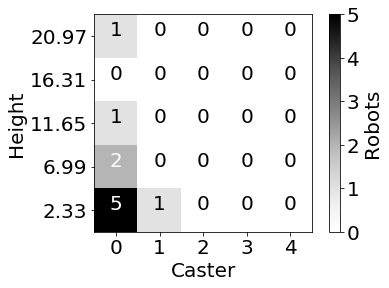

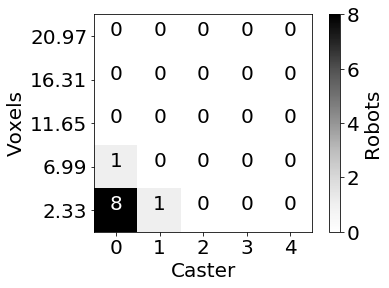

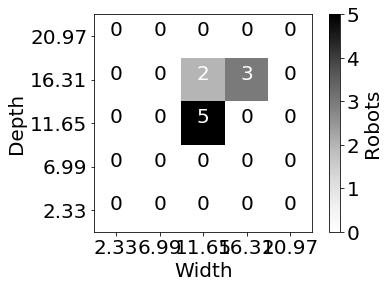

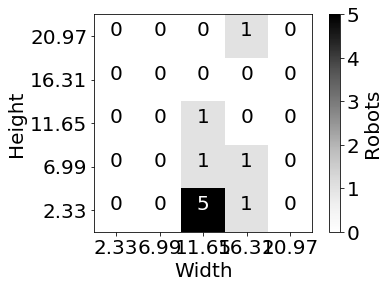

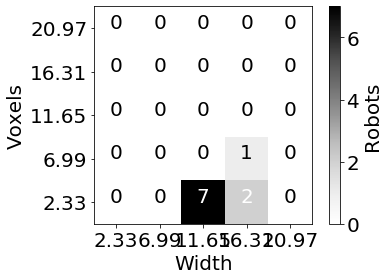

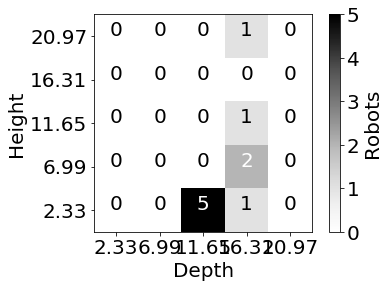

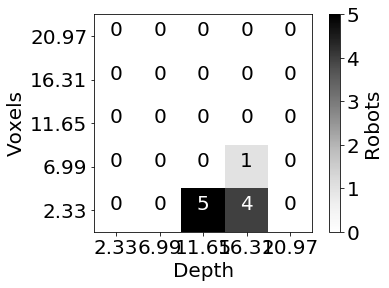

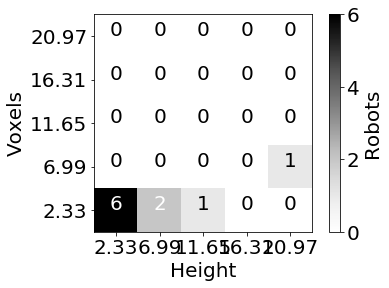

In [87]:
plot_histograms(hist_escape_rand,"escape_095_rand_100")

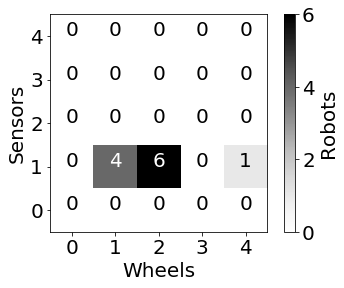

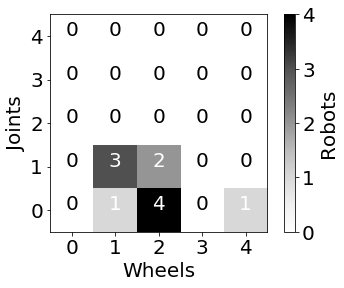

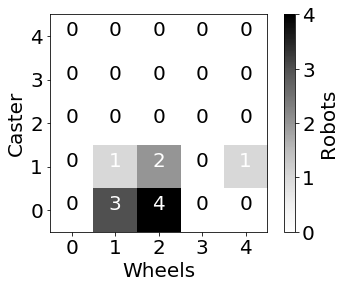

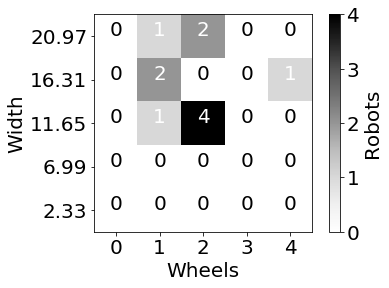

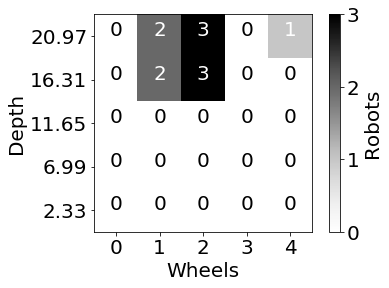

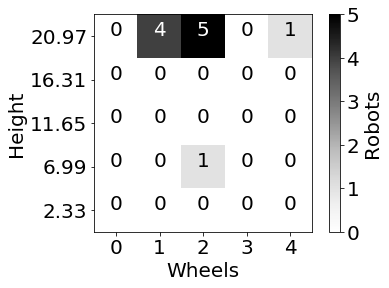

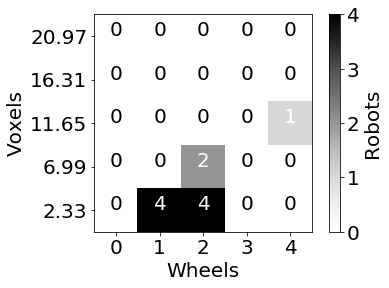

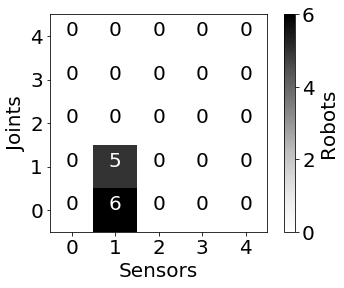

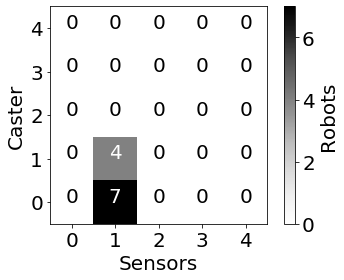

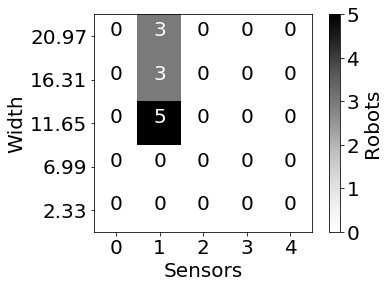

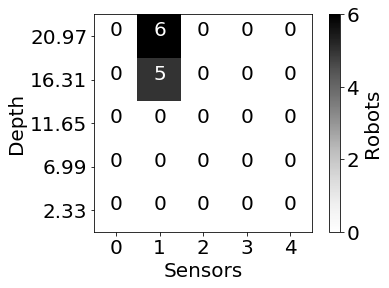

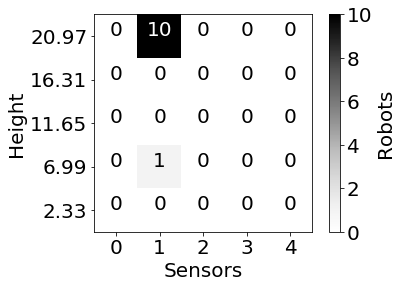

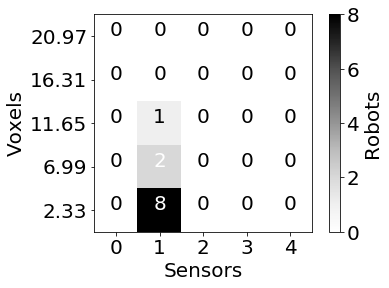

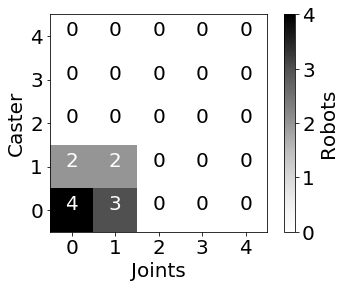

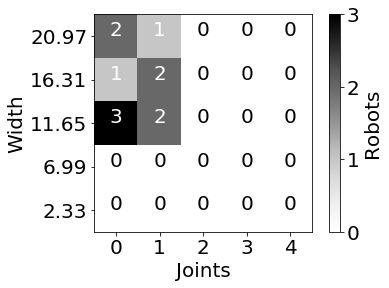

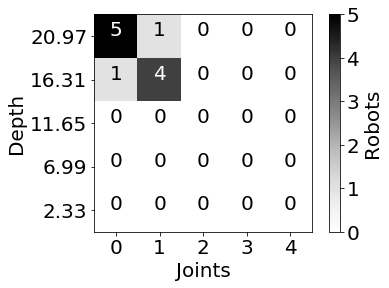

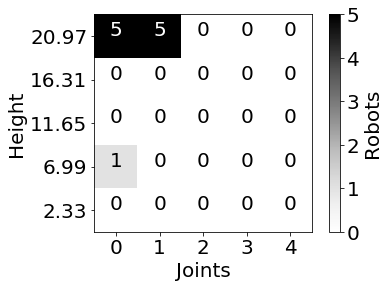

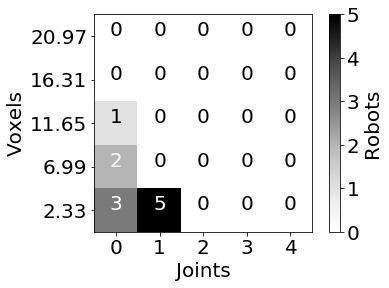

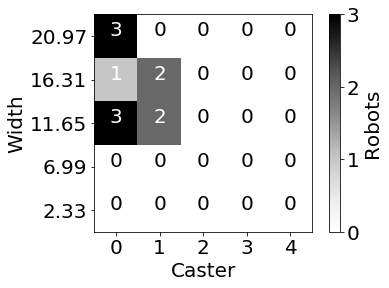

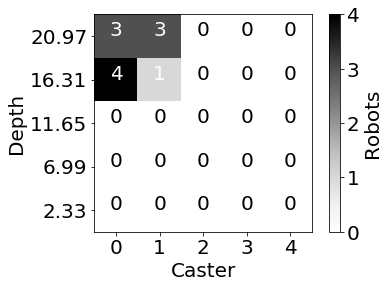

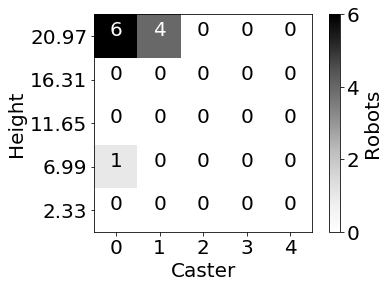

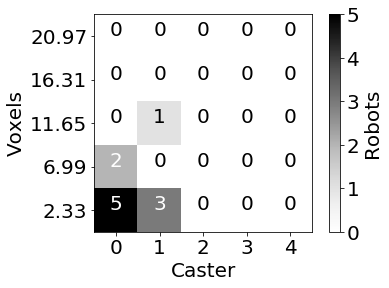

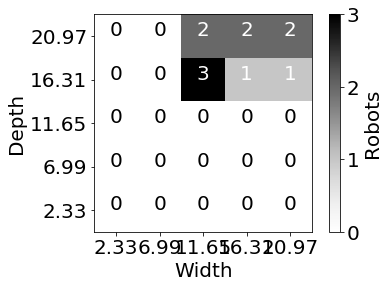

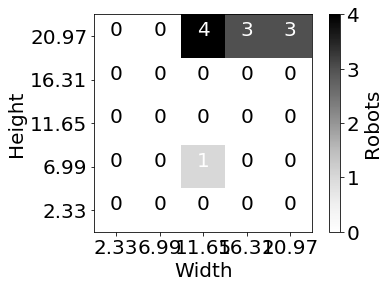

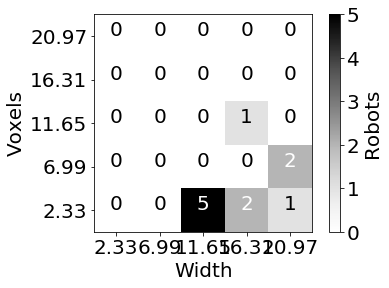

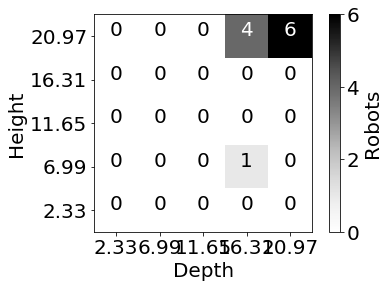

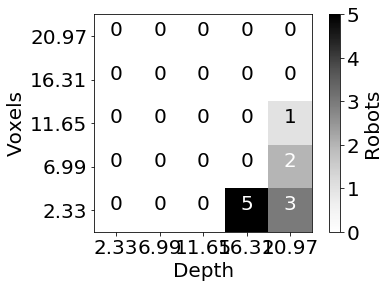

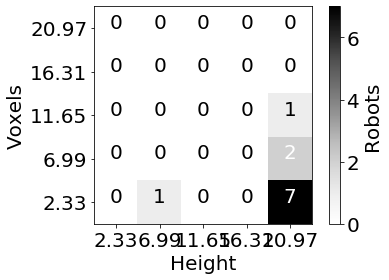

In [88]:
plot_histograms(hist_middle,"middle_095_100")

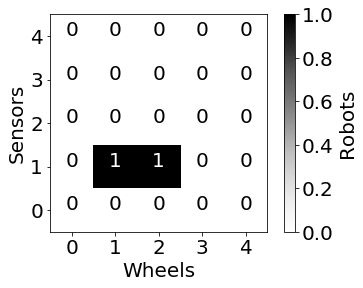

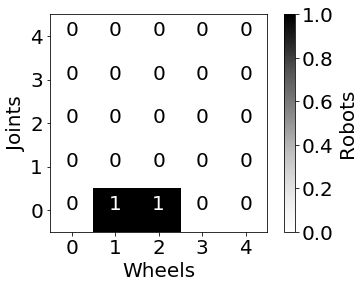

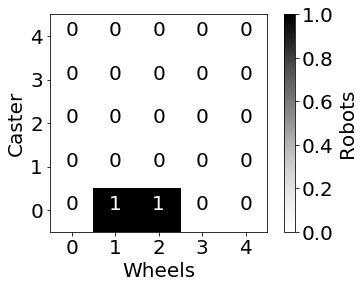

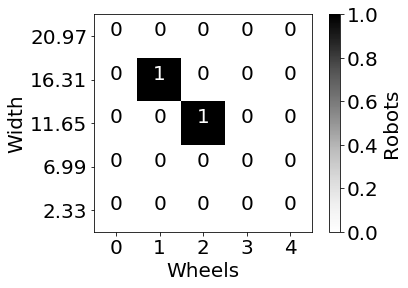

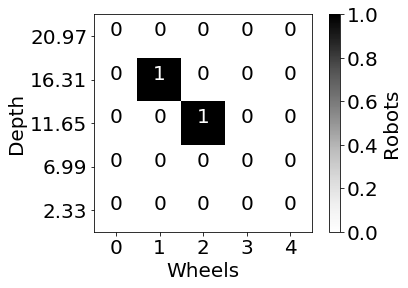

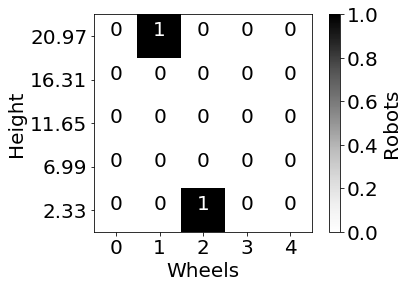

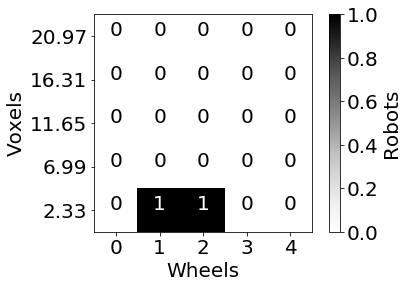

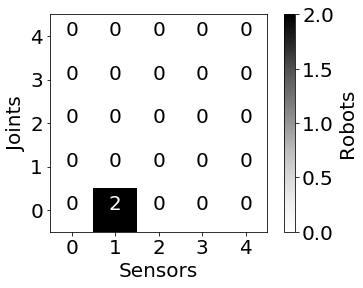

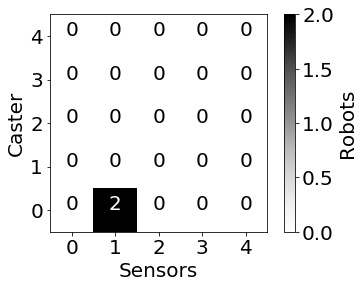

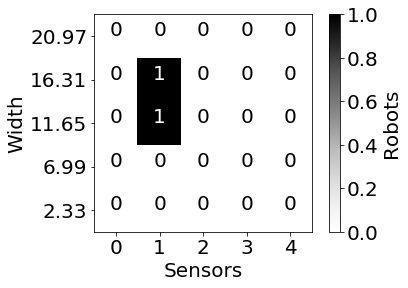

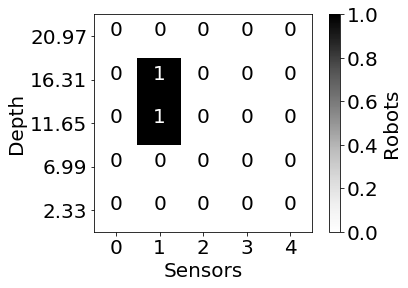

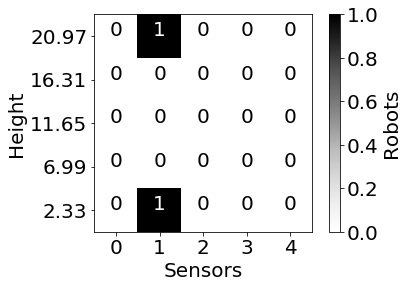

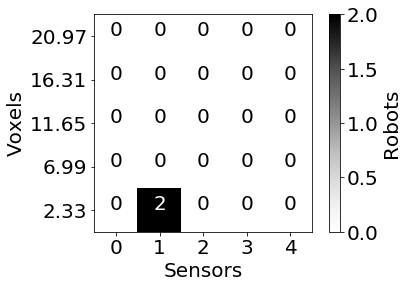

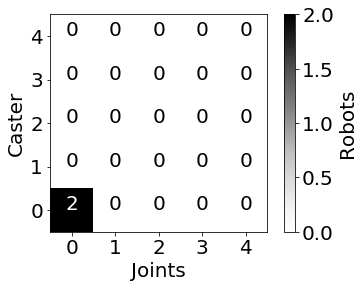

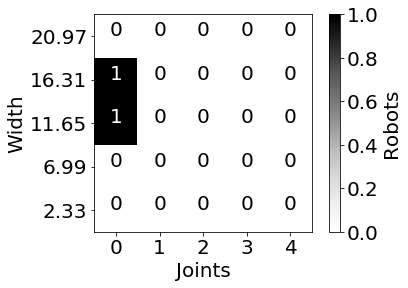

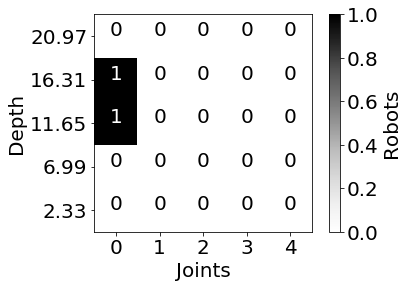

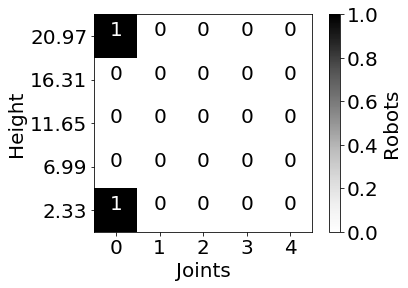

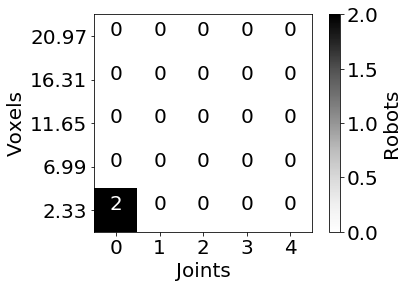

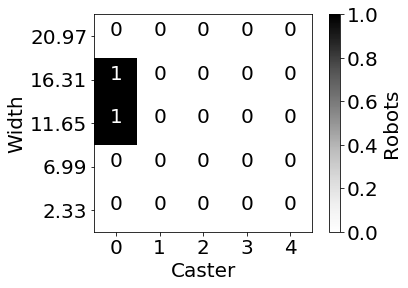

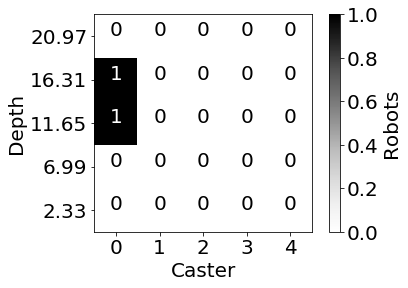

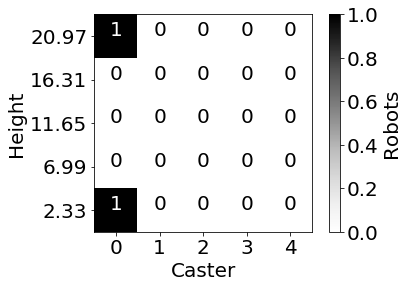

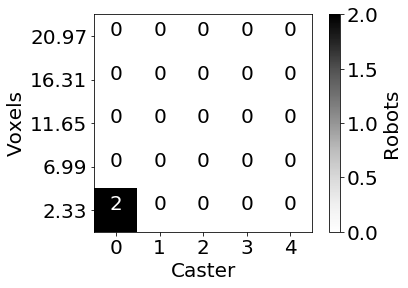

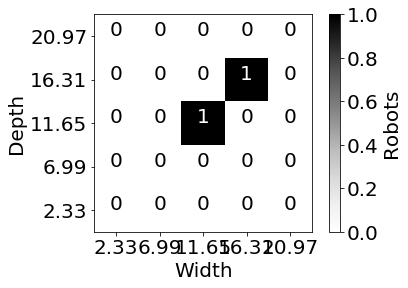

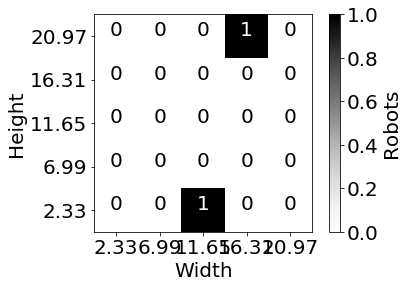

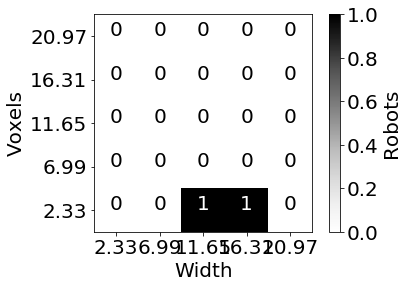

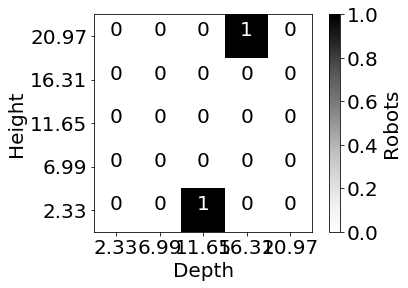

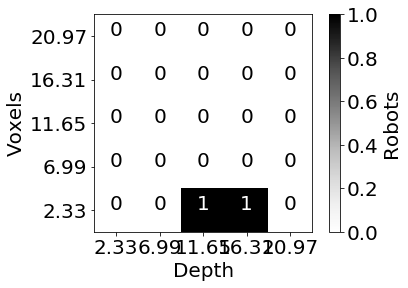

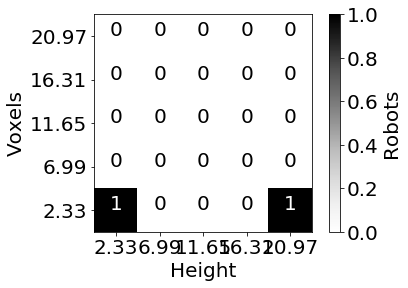

In [89]:
plot_histograms(hist_middle_rand,"middle_095_rand_100")

In [25]:
for index, line in d_arena.iterrows() :
    if(line["best fitness"] >= 0.95):
        print(line["morphology id"],line["genome folder"],line["number of evaluations"],line["best fitness"])

10972 lc_nsms_6_7_14-45-54-4729-2473138500 110 0.954702
21969 lc_nsms_6_7_14-45-54-4729-2473138500 50 0.950514
10562 lc_nsms_6_7_14-45-54-4729-2473138500 840 0.953114
15943 lc_nsms_6_7_14-45-54-4875-4076501458 100 0.954428
3073 lc_nsms_6_7_14-45-54-4875-4076501458 530 0.960726
5612 lc_nsms_6_7_14-45-54-4875-4076501458 250 0.952376
3939 lc_nsms_6_7_14-45-54-4875-4076501458 130 0.950566
28207 lc_nsms_6_7_14-45-54-4875-4076501458 260 0.957283
1704 lc_nsms_6_7_14-45-54-4875-4076501458 170 0.952955
13875 lc_nsms_6_7_14-45-54-4875-4076501458 110 0.950757
2567 lc_nsms_6_7_14-45-54-4875-4076501458 180 0.952917
9101 lc_nsms_6_7_14-45-54-4875-4076501458 310 0.952556
28702 lc_nsms_6_7_14-45-54-4875-4076501458 50 0.951375
10385 lc_nsms_6_7_14-45-54-4875-4076501458 840 0.95944
10414 lc_nsms_6_7_14-45-54-4771-2985634593 480 0.952047
6305 lc_nsms_6_7_14-45-54-4771-2985634593 70 0.952897
6642 lc_nsms_6_7_14-45-54-4771-2985634593 190 0.951957
14929 lc_nsms_6_7_14-45-54-4771-2985634593 120 0.954139
1710

In [16]:
hist_arena, hist_all_arena, d_arena = compute_dataframe("/home/leni/are-logs/pmn_arena_20201127-1/","",1000,0.63)

0.95 14.0 3.287180487219337 0.91 14.5 3.095695936834452 0.82 18.5 4.10960933531265 0.73 24.0 3.624760528488591
total number able to move :  316
600 600


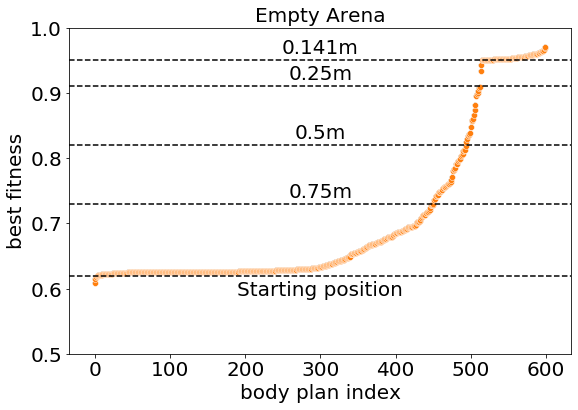

In [17]:
plot_best_fitness("Empty Arena",d_arena,d_arena,0.62)

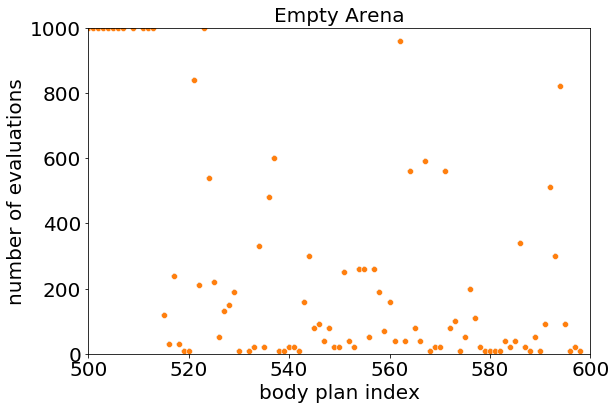

In [18]:
plot_number_eval("Empty Arena",d_arena,d_arena)

In [19]:
for index, line in d_arena.iterrows() :
    if(line["best fitness"] >= 0.95):
        print(line["morphology id"],line["genome folder"],line["number of evaluations"],line["best fitness"])

6576 lc_nsms_24_10_15-33-30-896-2962405988 40 0.952241
4941 lc_nsms_24_10_15-33-30-896-2962405988 10 0.964043
5774 lc_nsms_24_10_15-33-30-896-2962405988 130 0.951028
2350 lc_nsms_24_10_15-33-30-896-2962405988 10 0.960954
6703 lc_nsms_24_10_15-33-30-896-2962405988 10 0.95513
5401 lc_nsms_24_10_15-33-30-896-2962405988 210 0.950826
5346 lc_nsms_24_10_15-33-30-896-2962405988 260 0.953015
6044 lc_nsms_24_10_15-33-30-896-2962405988 80 0.952029
5373 lc_nsms_24_10_15-33-30-896-2962405988 10 0.951329
3435 lc_nsms_24_10_15-33-30-918-1070047268 120 0.950107
2428 lc_nsms_24_10_15-33-30-918-1070047268 10 0.95879
2237 lc_nsms_24_10_15-33-30-918-1070047268 10 0.95623
3235 lc_nsms_24_10_15-33-30-918-1070047268 1000 0.950907
2583 lc_nsms_24_10_15-33-30-918-1070047268 10 0.958117
2353 lc_nsms_24_10_15-33-30-918-1070047268 20 0.966218
3030 lc_nsms_24_10_15-33-30-918-1070047268 10 0.969065
4487 lc_nsms_24_10_15-33-30-918-1070047268 590 0.9546
2408 lc_nsms_24_10_15-33-30-918-1070047268 20 0.95886
2450 lc_n

In [18]:
hist_steps, hist_all_steps, d_steps = compute_dataframe("/home/leni/are-logs/pmn_steps/","",1000,0.63)

0.95 0.0 0.0 0.91 0.0 0.0 0.82 0.0 0.0 0.73 0.0 0.0
total number able to move :  40
100 100


<ipython-input-10-25e273972aef>:94: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  kmeans = skclust.KMeans(n_clusters=nbr_cluster, random_state=0).fit(desc_array)


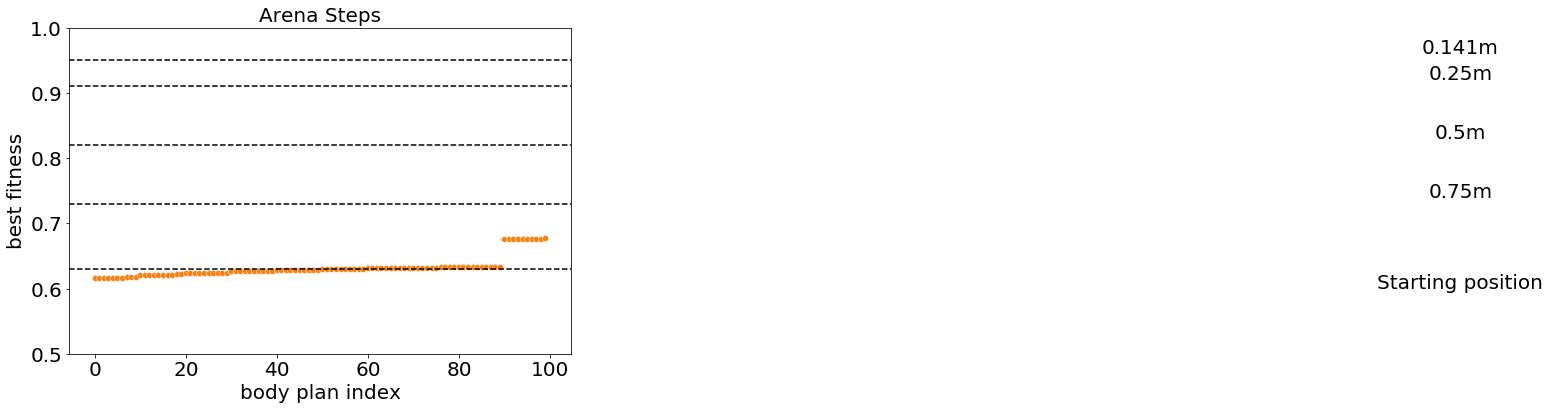

In [19]:
plot_best_fitness("Arena Steps",d_steps,d_steps,0.63)

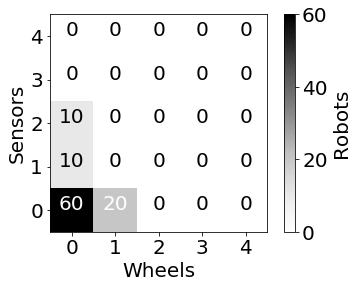

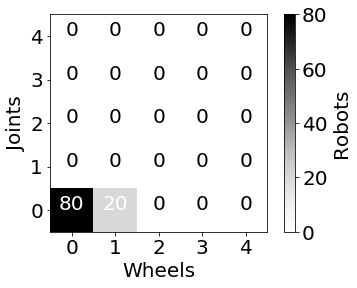

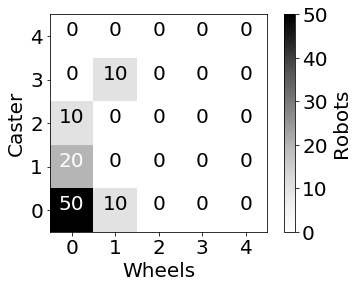

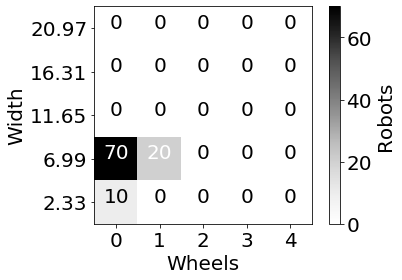

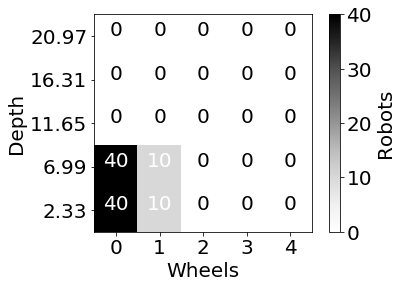

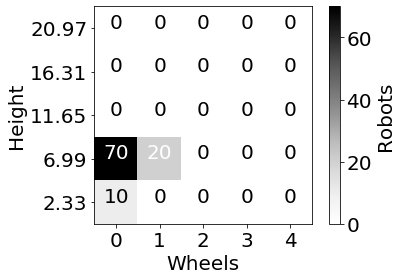

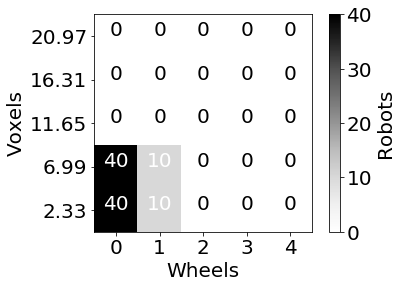

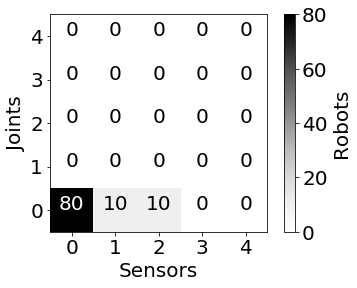

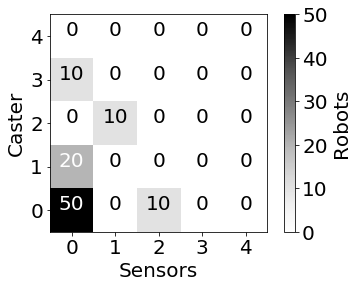

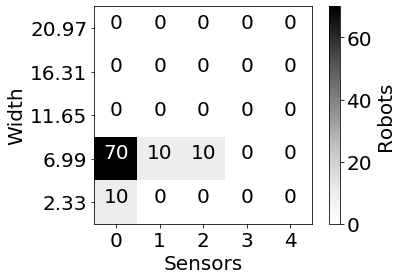

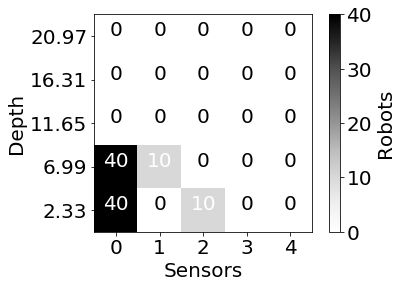

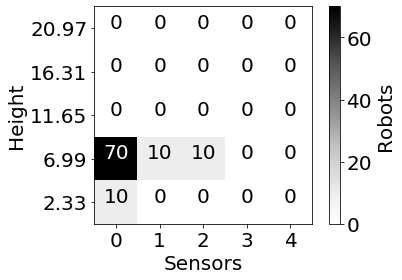

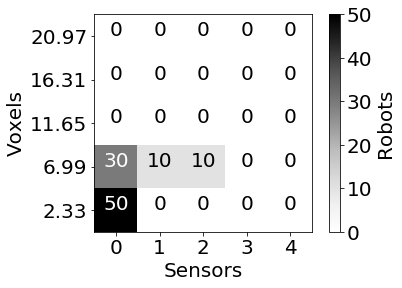

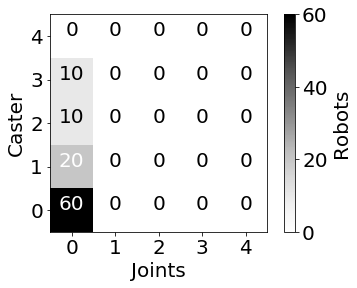

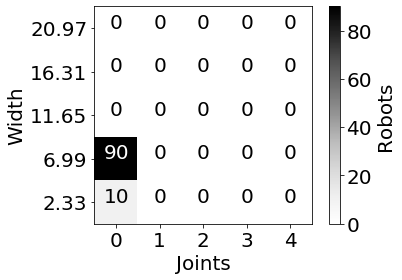

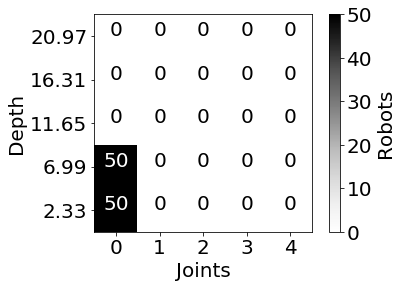

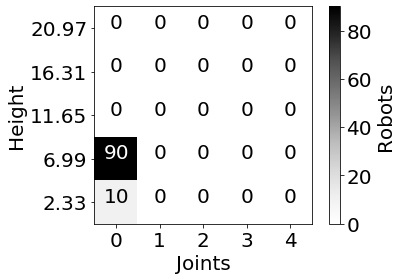

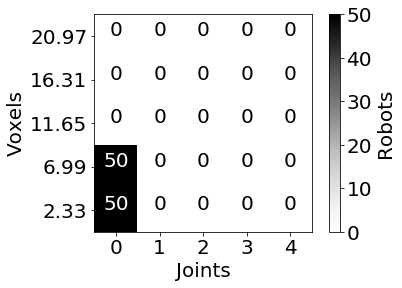

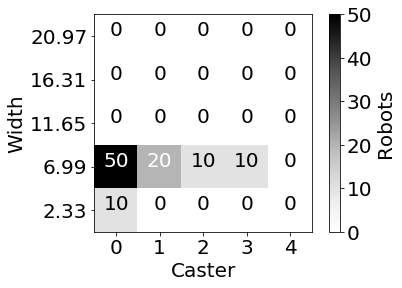

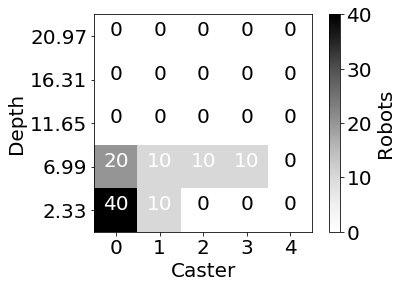

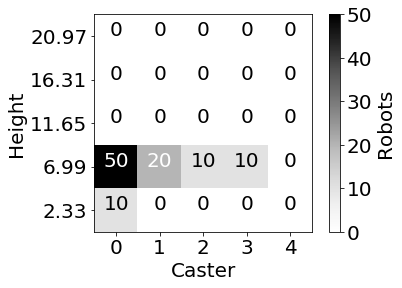

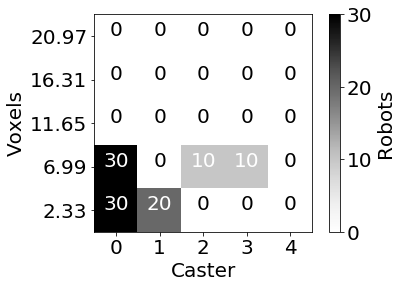

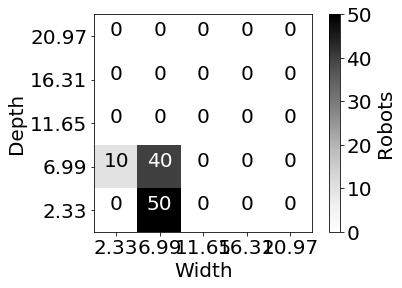

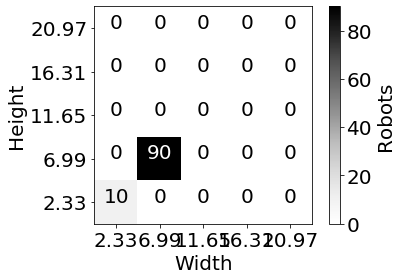

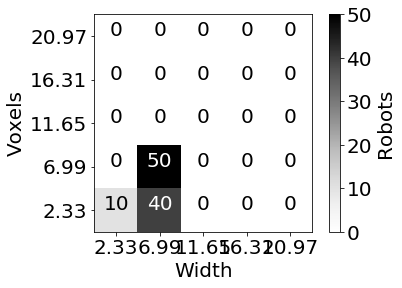

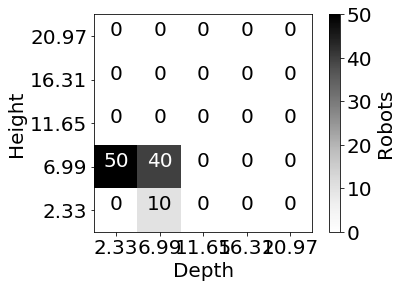

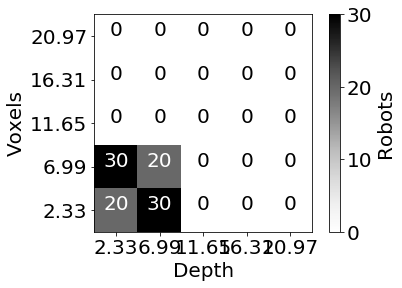

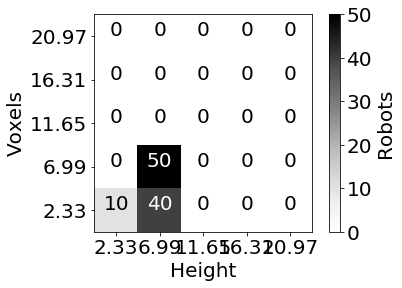

In [21]:
plot_histograms(hist_all_steps,"steps")